In [33]:
import pandas as pd
import numpy as np
import hickle as hkl

In [34]:
x = hkl.load('./data.hkl').astype(int)
y =  hkl.load("./label.hkl").astype(int)


In [35]:
x

array([[  0, 178,   1, ...,   4, 171,   4],
       [  2, 175,   2, ...,   6, 165,   7],
       [  0, 178,   1, ...,   4, 170,   4],
       ...,
       [  1, 176,   1, ...,   7, 166,   6],
       [  1, 176,   1, ...,   7, 166,   6],
       [  1, 176,   1, ...,   7, 166,   6]])

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def drawROC(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def drawConfusionMatrix(cm):
    import seaborn as sns
    import matplotlib.pyplot as plt     

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes']);
    ax.set_ylim([2, 0])
    plt.show()
    # xticklabels='auto', yticklabels='auto'

def vizReport(y_test, y_score, target_names=['0', '1']):

    y_pred = np.rint(y_score)   

    _accuracy = accuracy_score(y_test, y_pred)
    _precision = precision_score(y_test, y_pred)
    _recall = recall_score(y_test, y_pred)
    _f1 = f1_score(y_test, y_pred)
    _kappa = cohen_kappa_score(y_test, y_pred)
    _auc_roc = roc_auc_score(y_test, y_score).round(2)

#     _accuracy_w = balanced_accuracy_score(y_test, y_pred).round(2)
    _precision_w = precision_score(y_test, y_pred, average='weighted').round(2)
    _recall_w = recall_score(y_test, y_pred, average='weighted').round(2)
    _f1_w = f1_score(y_test, y_pred, average='weighted').round(2)

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    cnf_matrix = cm

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate

    print("--- Classification Report: {} ---".format(target))
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("Accuracy: ", _accuracy.round(2))
#     print("Accuracy(W): ", _accuracy_w.round(2))
    print("Precision: ", _precision.round(2))
    print("Precision(W): ", _precision_w.round(2))
    print("Recall: ", _recall.round(2))
    print("Recall(W): ", _recall_w.round(2))
    print("F1 Score: ", _f1.round(2))
    print("F1 Score(W): ", _f1_w.round(2))
    print("Kappa Stat: ", _kappa.round(2))
    print("AUC ROC: ", _auc_roc)

    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    drawROC(fpr, tpr, roc_auc)
    drawConfusionMatrix(cm)
    
    error_metrics_labels = [('FP', FP), ('FN', FN), ('TP', TP), ('TN', TN), ('TPR', TPR), ('TNR', TNR), ('FPR', FPR), ('FNR', FNR)]
    
    error_metric = {}
    for idx, t in enumerate(target_names):
        for e, em in error_metrics_labels:
            if e in error_metric.keys():
                error_metric[e][t] = em[idx]
            else:
                error_metric[e] = {}
                error_metric[e][t] = em[idx]
        
    e_df = pd.DataFrame(error_metric).round(2)
    print(e_df)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [ ]:
import numpy as np
import json
import shortuuid
import optuna.integration.lightgbm as lgb
# import lightgbm as lgb
from sklearn.metrics import f1_score

# mort_icu, los_3
# targets = ['Anxiety', 'Flow']
targets = ['Blow']
bst_params = {}

# 1. Start a W&B run
# wandb.init(project='aki', entity='pointnemo', name='{}-lgb'.format(target))
for target in targets:
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_valid, label=y_valid)

    params = {
        'boosting_type': 'dart',
        'objective': 'binary',
        'metric': 'auc',
#         'num_leaves': 30,
#         'learning_rate': 0.5,
#         'num_iterations': 1000,
#         'feature_fraction': 0.9,
#         'bagging_fraction': 0.8,
#         'bagging_freq': 5,
        'verbosity': 0
    }

    # 2. Add the wandb callback
    bst = gbm = lgb.train(params,
                   dtrain,
#                    num_boost_round=20,
                   valid_sets=[dtrain, dval],
                   valid_names=('Train', 'Validation'),
                   callbacks=[])

    # Get prediction
    pred = bst.predict(X_test, num_iteration=bst.best_iteration)
    vizReport(y_test, pred) 
    bst_params[target] = bst.params
    print('Model Params: ', bst.params)

# BST_PARAM_PATH = './artifacts/bst_params-{}.txt'.format(shortuuid.ShortUUID().random(length=5))
# with open(BST_PARAM_PATH, 'w') as outfile:
#     print('Saving Params: {}'.format(BST_PARAM_PATH))
#     json.dump(bst_params, outfile)

[I 2021-05-22 05:32:48,548] A new study created in memory with name: no-name-18841763-7eb8-43fa-b133-ec41b02831f8
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.657210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.929722	Validation's auc: 0.654003
[2]	Train's auc: 0.971519	Validation's auc: 0.752247
[3]	Train's auc: 0.987031	Validation's auc: 0.739175
[4]	Train's auc: 0.994039	Validation's auc: 0.731413
[5]	Train's auc: 0.997182	Validation's auc: 0.741013
[6]	Train's auc: 0.999013	Validation's auc: 0.763072
[7]	Train's auc: 0.999584	Validation's auc: 0.742239
[8]	Train's auc: 0.999568	Validation's auc: 0.729575
[9]	Train's auc: 0.999856	Validation's auc: 0.738562
[10]	Train's auc: 0.999915	Validation's auc: 0.741013
[11]	Train's auc: 1	Validation's auc: 0.746732
[12]	Train's auc: 0.999979	Validation's auc: 0.747549
[13]	Train's auc: 1	Validation's auc: 0.750408
[14]	Train's auc: 1	Validation's auc: 0.767565
[15]	Train's auc: 1	Validation's a

[168]	Train's auc: 1	Validation's auc: 0.874592
[169]	Train's auc: 1	Validation's auc: 0.88031
[170]	Train's auc: 1	Validation's auc: 0.879902
[171]	Train's auc: 1	Validation's auc: 0.882353
[172]	Train's auc: 1	Validation's auc: 0.882353
[173]	Train's auc: 1	Validation's auc: 0.884395
[174]	Train's auc: 1	Validation's auc: 0.882761
[175]	Train's auc: 1	Validation's auc: 0.881536
[176]	Train's auc: 1	Validation's auc: 0.881127
[177]	Train's auc: 1	Validation's auc: 0.880719
[178]	Train's auc: 1	Validation's auc: 0.881127
[179]	Train's auc: 1	Validation's auc: 0.881944
[180]	Train's auc: 1	Validation's auc: 0.882353
[181]	Train's auc: 1	Validation's auc: 0.883987
[182]	Train's auc: 1	Validation's auc: 0.883578
[183]	Train's auc: 1	Validation's auc: 0.884395
[184]	Train's auc: 1	Validation's auc: 0.885212
[185]	Train's auc: 1	Validation's auc: 0.885212
[186]	Train's auc: 1	Validation's auc: 0.88848
[187]	Train's auc: 1	Validation's auc: 0.890114
[188]	Train's auc: 1	Validation's auc: 0.8

[339]	Train's auc: 1	Validation's auc: 0.904003
[340]	Train's auc: 1	Validation's auc: 0.904412
[341]	Train's auc: 1	Validation's auc: 0.902778
[342]	Train's auc: 1	Validation's auc: 0.904003
[343]	Train's auc: 1	Validation's auc: 0.904412
[344]	Train's auc: 1	Validation's auc: 0.904412
[345]	Train's auc: 1	Validation's auc: 0.905229
[346]	Train's auc: 1	Validation's auc: 0.906046
[347]	Train's auc: 1	Validation's auc: 0.905637
[348]	Train's auc: 1	Validation's auc: 0.906863
[349]	Train's auc: 1	Validation's auc: 0.90768
[350]	Train's auc: 1	Validation's auc: 0.90768
[351]	Train's auc: 1	Validation's auc: 0.908905
[352]	Train's auc: 1	Validation's auc: 0.910131
[353]	Train's auc: 1	Validation's auc: 0.90768
[354]	Train's auc: 1	Validation's auc: 0.908497
[355]	Train's auc: 1	Validation's auc: 0.90768
[356]	Train's auc: 1	Validation's auc: 0.908905
[357]	Train's auc: 1	Validation's auc: 0.908905
[358]	Train's auc: 1	Validation's auc: 0.909314
[359]	Train's auc: 1	Validation's auc: 0.908

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	Train's auc: 1	Validation's auc: 0.911765
[490]	Train's auc: 1	Validation's auc: 0.911765
[491]	Train's auc: 1	Validation's auc: 0.911356
[492]	Train's auc: 1	Validation's auc: 0.910948
[493]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[582]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[583]	Train's auc: 1	Validation's auc: 0.910131
[584]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[585]	Train's auc: 1	Validation's auc: 0.908905
[586]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	Train's auc: 1	Validation's auc: 0.908497
[588]	Train's auc: 1	Validation's auc: 0.908497
[589]	Train's auc: 1	Validation's auc: 0.908497
[590]	Train's auc: 1	Validation's auc: 0.908497
[591]	Train's auc: 1	Validation's auc: 0.908497
[592]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	Train's auc: 1	Validation's auc: 0.910131
[594]	Train's auc: 1	Validation's auc: 0.910131
[595]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No furth

[678]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	Train's auc: 1	Validation's auc: 0.90768
[681]	Train's auc: 1	Validation's auc: 0.90768
[682]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	Train's auc: 1	Validation's auc: 0.908497
[685]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.908905
[687]	Train's auc: 1	Validation's auc: 0.908905
[688]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	Train's auc: 1	Vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[766]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[767]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[768]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[769]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	Train's auc: 1	Validation's auc: 0.909314
[773]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[774]	Train's au

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[841]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[842]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[843]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[844]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[908]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[909]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[910]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[911]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[912]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warn

feature_fraction, val_score: 0.910131:  14%|#4        | 1/7 [10:34<1:03:25, 634.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.838941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.923056	Validation's auc: 0.667892
[2]	Train's auc: 0.962238	Validation's auc: 0.725286
[3]	Train's auc: 0.97926	Validation's auc: 0.747753
[4]	Train's auc: 0.987893	Validation's auc: 0.754085
[5]	Train's auc: 0.993056	Validation's auc: 0.756127
[6]	Train's auc: 0.996024	Validation's auc: 0.798203
[7]	Train's auc: 0.998308	Validation's auc: 0.798203
[8]	Train's auc: 0.99866	Validation's auc: 0.79085
[9]	Train's auc: 0.999045	Validation's auc: 0.822304
[10]	Train's auc: 0.999536	Validation's auc: 0.809232
[11]	Train's auc: 0.999765	Validation's auc: 0.811683
[12]	Train's auc: 0.999776	Validation's auc: 0.819853
[13]	Train's auc: 0.999845	Validation's auc: 0.833333
[14]	Train's auc: 0.999941	Validation's auc: 0.845997
[15]	Train's auc: 0.999989	Validation's auc: 0.839052
[16]	Train's auc: 1	Validation's auc:

[169]	Train's auc: 1	Validation's auc: 0.887255
[170]	Train's auc: 1	Validation's auc: 0.888072
[171]	Train's auc: 1	Validation's auc: 0.888889
[172]	Train's auc: 1	Validation's auc: 0.889297
[173]	Train's auc: 1	Validation's auc: 0.889297
[174]	Train's auc: 1	Validation's auc: 0.887663
[175]	Train's auc: 1	Validation's auc: 0.890931
[176]	Train's auc: 1	Validation's auc: 0.889706
[177]	Train's auc: 1	Validation's auc: 0.889297
[178]	Train's auc: 1	Validation's auc: 0.890114
[179]	Train's auc: 1	Validation's auc: 0.892974
[180]	Train's auc: 1	Validation's auc: 0.893791
[181]	Train's auc: 1	Validation's auc: 0.892565
[182]	Train's auc: 1	Validation's auc: 0.895016
[183]	Train's auc: 1	Validation's auc: 0.892565
[184]	Train's auc: 1	Validation's auc: 0.890523
[185]	Train's auc: 1	Validation's auc: 0.890523
[186]	Train's auc: 1	Validation's auc: 0.892974
[187]	Train's auc: 1	Validation's auc: 0.896242
[188]	Train's auc: 1	Validation's auc: 0.89951
[189]	Train's auc: 1	Validation's auc: 0.

[340]	Train's auc: 1	Validation's auc: 0.902369
[341]	Train's auc: 1	Validation's auc: 0.900327
[342]	Train's auc: 1	Validation's auc: 0.900327
[343]	Train's auc: 1	Validation's auc: 0.898284
[344]	Train's auc: 1	Validation's auc: 0.898284
[345]	Train's auc: 1	Validation's auc: 0.897876
[346]	Train's auc: 1	Validation's auc: 0.899101
[347]	Train's auc: 1	Validation's auc: 0.899101
[348]	Train's auc: 1	Validation's auc: 0.898284
[349]	Train's auc: 1	Validation's auc: 0.89665
[350]	Train's auc: 1	Validation's auc: 0.896242
[351]	Train's auc: 1	Validation's auc: 0.89665
[352]	Train's auc: 1	Validation's auc: 0.898693
[353]	Train's auc: 1	Validation's auc: 0.89665
[354]	Train's auc: 1	Validation's auc: 0.897059
[355]	Train's auc: 1	Validation's auc: 0.897059
[356]	Train's auc: 1	Validation's auc: 0.897467
[357]	Train's auc: 1	Validation's auc: 0.897876
[358]	Train's auc: 1	Validation's auc: 0.896242
[359]	Train's auc: 1	Validation's auc: 0.896242
[360]	Train's auc: 1	Validation's auc: 0.89

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	Train's auc: 1	Validation's auc: 0.90482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	Train's auc: 1	Validation's auc: 0.90482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	Train's auc: 1	Validation's auc: 0.906454
[499]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	Train's auc: 1	Validation's auc: 0.906046
[501]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[502]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with p

[588]	Train's auc: 1	Validation's auc: 0.901961
[589]	Train's auc: 1	Validation's auc: 0.901144
[590]	Train's auc: 1	Validation's auc: 0.901144
[591]	Train's auc: 1	Validation's auc: 0.900735
[592]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	Train's auc: 1	Validation's auc: 0.903595
[594]	Train's auc: 1	Validation's auc: 0.903186
[595]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	Train's auc: 1	Validation's auc: 0.901961
[597]	Train's auc: 1	Validation's auc: 0.902369
[598]	Train's auc: 1	Validation's auc: 0.902369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	Train's auc: 1	Validation's auc: 0.900735
[685]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.900327
[687]	Train's auc: 1	Validation's auc: 0.900327
[688]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	Train's auc: 1	Validation's auc: 0.900735
[691]	Train's auc: 1	Validation's auc: 0.900327
[692]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[693]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[694]	Train's auc: 1	Validation's auc: 0.89951
[695]	Train's auc: 1	Va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[775]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[776]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[777]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[778]	Train's auc: 1	Validation's auc: 0.902369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[779]	Train's auc: 1	Validation's auc: 0.901961
[780]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[781]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[782]	Train's auc: 1	Validation's auc: 0.900735
[783]	Train's auc: 1	Validation's auc: 0.900735
[784]	Train's auc: 1	Validation's auc: 0.90

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[852]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[853]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[854]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[855]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[856]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[857]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[858]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[919]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[921]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[922]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[923]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	Train's auc: 1	Validation's auc: 0.902369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warn

feature_fraction, val_score: 0.910131:  29%|##8       | 2/7 [19:03<49:42, 596.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.469465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[2]	Train's auc: 0.96643	Validation's auc: 0.808211
[3]	Train's auc: 0.979554	Validation's auc: 0.817402
[4]	Train's auc: 0.989563	Validation's auc: 0.80719
[5]	Train's auc: 0.995226	Validation's auc: 0.800858
[6]	Train's auc: 0.997908	Validation's auc: 0.799224
[7]	Train's auc: 0.999322	Validation's auc: 0.81781
[8]	Train's auc: 0.999397	Validation's auc: 0.804739
[9]	Train's auc: 0.999504	Validation's auc: 0.816993
[10]	Train's auc: 0.999765	Validation's auc: 0.817402
[11]	Train's auc: 0.999851	Validation's auc: 0.803922
[12]	Train's auc: 0.999845	Validation's auc: 0.80719
[13]	Train's auc: 0.999936	Validation's auc: 0.815359
[14]	Train's auc: 0.999984	Validation's auc: 0.817402
[15]	Train's auc: 0.999995	Validation's auc: 0.812908
[16]	Train's auc: 0.999995	Validation'

[169]	Train's auc: 1	Validation's auc: 0.889297
[170]	Train's auc: 1	Validation's auc: 0.889706
[171]	Train's auc: 1	Validation's auc: 0.892974
[172]	Train's auc: 1	Validation's auc: 0.892565
[173]	Train's auc: 1	Validation's auc: 0.89134
[174]	Train's auc: 1	Validation's auc: 0.893791
[175]	Train's auc: 1	Validation's auc: 0.898284
[176]	Train's auc: 1	Validation's auc: 0.898284
[177]	Train's auc: 1	Validation's auc: 0.89665
[178]	Train's auc: 1	Validation's auc: 0.897059
[179]	Train's auc: 1	Validation's auc: 0.899918
[180]	Train's auc: 1	Validation's auc: 0.899918
[181]	Train's auc: 1	Validation's auc: 0.895425
[182]	Train's auc: 1	Validation's auc: 0.890931
[183]	Train's auc: 1	Validation's auc: 0.892974
[184]	Train's auc: 1	Validation's auc: 0.89134
[185]	Train's auc: 1	Validation's auc: 0.891748
[186]	Train's auc: 1	Validation's auc: 0.892565
[187]	Train's auc: 1	Validation's auc: 0.892974
[188]	Train's auc: 1	Validation's auc: 0.892157
[189]	Train's auc: 1	Validation's auc: 0.89

[341]	Train's auc: 1	Validation's auc: 0.904412
[342]	Train's auc: 1	Validation's auc: 0.905229
[343]	Train's auc: 1	Validation's auc: 0.904003
[344]	Train's auc: 1	Validation's auc: 0.904003
[345]	Train's auc: 1	Validation's auc: 0.901961
[346]	Train's auc: 1	Validation's auc: 0.903595
[347]	Train's auc: 1	Validation's auc: 0.904412
[348]	Train's auc: 1	Validation's auc: 0.902778
[349]	Train's auc: 1	Validation's auc: 0.902369
[350]	Train's auc: 1	Validation's auc: 0.901961
[351]	Train's auc: 1	Validation's auc: 0.901552
[352]	Train's auc: 1	Validation's auc: 0.901961
[353]	Train's auc: 1	Validation's auc: 0.902778
[354]	Train's auc: 1	Validation's auc: 0.903186
[355]	Train's auc: 1	Validation's auc: 0.902778
[356]	Train's auc: 1	Validation's auc: 0.905229
[357]	Train's auc: 1	Validation's auc: 0.905229
[358]	Train's auc: 1	Validation's auc: 0.903186
[359]	Train's auc: 1	Validation's auc: 0.903595
[360]	Train's auc: 1	Validation's auc: 0.904003
[361]	Train's auc: 1	Validation's auc: 0

[490]	Train's auc: 1	Validation's auc: 0.916667
[491]	Train's auc: 1	Validation's auc: 0.916667
[492]	Train's auc: 1	Validation's auc: 0.916667
[493]	Train's auc: 1	Validation's auc: 0.916667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	Train's auc: 1	Validation's auc: 0.915033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	Train's auc: 1	Validation's auc: 0.916258
[499]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	Train's auc: 1	Validation's auc: 0.915033
[501]	Train's auc: 1	Val

[586]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	Train's auc: 1	Validation's auc: 0.91299
[588]	Train's auc: 1	Validation's auc: 0.91299
[589]	Train's auc: 1	Validation's auc: 0.91299
[590]	Train's auc: 1	Validation's auc: 0.91299
[591]	Train's auc: 1	Validation's auc: 0.91299
[592]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	Train's auc: 1	Validation's auc: 0.911765
[594]	Train's auc: 1	Validation's auc: 0.911765
[595]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	Train's auc: 1	Validation's auc: 0.91299
[597]	Train's auc: 1	Validation's auc: 0.913399
[598]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further spl

[681]	Train's auc: 1	Validation's auc: 0.915441
[682]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	Train's auc: 1	Validation's auc: 0.916667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	Train's auc: 1	Validation's auc: 0.916258
[685]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.916667
[687]	Train's auc: 1	Validation's auc: 0.916667
[688]	Train's auc: 1	Validation's auc: 0.916667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	Train's auc: 1	Validation's auc: 0.916258
[691]	Train's auc: 1	Validation's auc: 0.916258
[692]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positi

[768]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[769]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	Train's auc: 1	Validation's auc: 0.917484
[773]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[774]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[775]	Train's auc: 1	Validation's auc: 0.916667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[776]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[849]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[850]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[852]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[912]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[916]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[917]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[918]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[919]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warni

feature_fraction, val_score: 0.912582:  43%|####2     | 3/7 [31:55<43:15, 648.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.418038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.928753	Validation's auc: 0.771446
[2]	Train's auc: 0.965715	Validation's auc: 0.731618
[3]	Train's auc: 0.980773	Validation's auc: 0.804739
[4]	Train's auc: 0.992072	Validation's auc: 0.831291
[5]	Train's auc: 0.996024	Validation's auc: 0.85049
[6]	Train's auc: 0.998383	Validation's auc: 0.836601
[7]	Train's auc: 0.999007	Validation's auc: 0.843137
[8]	Train's auc: 0.99913	Validation's auc: 0.851307
[9]	Train's auc: 0.999803	Validation's auc: 0.84518
[10]	Train's auc: 0.999893	Validation's auc: 0.848448
[11]	Train's auc: 0.999957	Validation's auc: 0.839869
[12]	Train's auc: 0.999947	Validation's auc: 0.843954
[13]	Train's auc: 0.999984	Validation's auc: 0.856209
[14]	Train's auc: 0.999995	Validation's auc: 0.857026
[15]	Train's auc: 0.999984	Validation's auc: 0.843546
[16]	Train's auc: 1	Validation's auc:

[169]	Train's auc: 1	Validation's auc: 0.874183
[170]	Train's auc: 1	Validation's auc: 0.873366
[171]	Train's auc: 1	Validation's auc: 0.875408
[172]	Train's auc: 1	Validation's auc: 0.874592
[173]	Train's auc: 1	Validation's auc: 0.876634
[174]	Train's auc: 1	Validation's auc: 0.872549
[175]	Train's auc: 1	Validation's auc: 0.873775
[176]	Train's auc: 1	Validation's auc: 0.873775
[177]	Train's auc: 1	Validation's auc: 0.873366
[178]	Train's auc: 1	Validation's auc: 0.873366
[179]	Train's auc: 1	Validation's auc: 0.875
[180]	Train's auc: 1	Validation's auc: 0.874592
[181]	Train's auc: 1	Validation's auc: 0.870098
[182]	Train's auc: 1	Validation's auc: 0.874183
[183]	Train's auc: 1	Validation's auc: 0.875817
[184]	Train's auc: 1	Validation's auc: 0.877042
[185]	Train's auc: 1	Validation's auc: 0.875817
[186]	Train's auc: 1	Validation's auc: 0.875408
[187]	Train's auc: 1	Validation's auc: 0.879902
[188]	Train's auc: 1	Validation's auc: 0.882761
[189]	Train's auc: 1	Validation's auc: 0.88

[341]	Train's auc: 1	Validation's auc: 0.910539
[342]	Train's auc: 1	Validation's auc: 0.910131
[343]	Train's auc: 1	Validation's auc: 0.911356
[344]	Train's auc: 1	Validation's auc: 0.911356
[345]	Train's auc: 1	Validation's auc: 0.911356
[346]	Train's auc: 1	Validation's auc: 0.910131
[347]	Train's auc: 1	Validation's auc: 0.910131
[348]	Train's auc: 1	Validation's auc: 0.910948
[349]	Train's auc: 1	Validation's auc: 0.910948
[350]	Train's auc: 1	Validation's auc: 0.910948
[351]	Train's auc: 1	Validation's auc: 0.909722
[352]	Train's auc: 1	Validation's auc: 0.909314
[353]	Train's auc: 1	Validation's auc: 0.910539
[354]	Train's auc: 1	Validation's auc: 0.909722
[355]	Train's auc: 1	Validation's auc: 0.909722
[356]	Train's auc: 1	Validation's auc: 0.910539
[357]	Train's auc: 1	Validation's auc: 0.909722
[358]	Train's auc: 1	Validation's auc: 0.908497
[359]	Train's auc: 1	Validation's auc: 0.908497
[360]	Train's auc: 1	Validation's auc: 0.907271
[361]	Train's auc: 1	Validation's auc: 0

[490]	Train's auc: 1	Validation's auc: 0.905637
[491]	Train's auc: 1	Validation's auc: 0.905229
[492]	Train's auc: 1	Validation's auc: 0.905229
[493]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	Train's auc: 1	Validation's auc: 0.904412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	Train's auc: 1	Validation's auc: 0.903595
[499]	Train's auc: 1	Validation's auc: 0.904003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	Train's auc: 1	Validation's auc: 0.90482
[501]	Train's auc: 1	Va

[586]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	Train's auc: 1	Validation's auc: 0.902778
[588]	Train's auc: 1	Validation's auc: 0.902778
[589]	Train's auc: 1	Validation's auc: 0.902778
[590]	Train's auc: 1	Validation's auc: 0.902778
[591]	Train's auc: 1	Validation's auc: 0.902369
[592]	Train's auc: 1	Validation's auc: 0.902369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	Train's auc: 1	Validation's auc: 0.903186
[594]	Train's auc: 1	Validation's auc: 0.903186
[595]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	Train's auc: 1	Validation's auc: 0.902369
[597]	Train's auc: 1	Validation's auc: 0.902369
[598]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No furt

[681]	Train's auc: 1	Validation's auc: 0.902778
[682]	Train's auc: 1	Validation's auc: 0.902369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	Train's auc: 1	Validation's auc: 0.904412
[685]	Train's auc: 1	Validation's auc: 0.904412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.903595
[687]	Train's auc: 1	Validation's auc: 0.903595
[688]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	Train's auc: 1	Validation's auc: 0.90482
[691]	Train's auc: 1	Validation's auc: 0.90482
[692]	Train's auc: 1	Validation's auc: 0.90482
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[769]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	Train's auc: 1	Validation's auc: 0.900735
[773]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[774]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[775]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[776]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[777]	Train's au

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[849]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[850]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[852]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[853]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[854]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	Train's auc: 1	Validation's auc: 0.892974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[916]	Train's auc: 1	Validation's auc: 0.893382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[917]	Train's auc: 1	Validation's auc: 0.893382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[918]	Train's auc: 1	Validation's auc: 0.892974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[919]	Train's auc: 1	Validation's auc: 0.892974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	Train's auc: 1	Validation's auc: 0.892974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[921]	Train's auc: 1	Validation's auc: 0.892565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[922]	Train's auc: 1	Validation's auc: 0.892565
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	Train's auc: 1	Validation's auc: 0.89665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	Train's auc: 1	Validation's auc: 0.89665
[LightGBM] [Warnin

feature_fraction, val_score: 0.912582:  57%|#####7    | 4/7 [43:57<33:32, 670.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.411675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.931464	Validation's auc: 0.678717
[2]	Train's auc: 0.963222	Validation's auc: 0.756944
[3]	Train's auc: 0.983751	Validation's auc: 0.757149
[4]	Train's auc: 0.991493	Validation's auc: 0.800245
[5]	Train's auc: 0.996472	Validation's auc: 0.814134
[6]	Train's auc: 0.998426	Validation's auc: 0.804739
[7]	Train's auc: 0.999461	Validation's auc: 0.801471
[8]	Train's auc: 0.99953	Validation's auc: 0.79902
[9]	Train's auc: 0.999968	Validation's auc: 0.810049
[10]	Train's auc: 0.999957	Validation's auc: 0.800654
[11]	Train's auc: 0.999984	Validation's auc: 0.798203
[12]	Train's auc: 0.999979	Validation's auc: 0.808824
[13]	Train's auc: 0.999989	Validation's auc: 0.814951
[14]	Train's auc: 1	Validation's auc: 0.824755
[15]	Train's auc: 1	Validation's auc: 0.823529
[16]	Train's auc: 1	Validation's auc: 0.826389
[17

[170]	Train's auc: 1	Validation's auc: 0.889706
[171]	Train's auc: 1	Validation's auc: 0.887255
[172]	Train's auc: 1	Validation's auc: 0.886438
[173]	Train's auc: 1	Validation's auc: 0.889706
[174]	Train's auc: 1	Validation's auc: 0.886846
[175]	Train's auc: 1	Validation's auc: 0.889297
[176]	Train's auc: 1	Validation's auc: 0.889297
[177]	Train's auc: 1	Validation's auc: 0.889297
[178]	Train's auc: 1	Validation's auc: 0.890114
[179]	Train's auc: 1	Validation's auc: 0.88848
[180]	Train's auc: 1	Validation's auc: 0.88848
[181]	Train's auc: 1	Validation's auc: 0.888072
[182]	Train's auc: 1	Validation's auc: 0.886029
[183]	Train's auc: 1	Validation's auc: 0.886846
[184]	Train's auc: 1	Validation's auc: 0.886029
[185]	Train's auc: 1	Validation's auc: 0.885212
[186]	Train's auc: 1	Validation's auc: 0.888889
[187]	Train's auc: 1	Validation's auc: 0.890523
[188]	Train's auc: 1	Validation's auc: 0.887255
[189]	Train's auc: 1	Validation's auc: 0.886438
[190]	Train's auc: 1	Validation's auc: 0.8

[342]	Train's auc: 1	Validation's auc: 0.905637
[343]	Train's auc: 1	Validation's auc: 0.905637
[344]	Train's auc: 1	Validation's auc: 0.905637
[345]	Train's auc: 1	Validation's auc: 0.906046
[346]	Train's auc: 1	Validation's auc: 0.906454
[347]	Train's auc: 1	Validation's auc: 0.906046
[348]	Train's auc: 1	Validation's auc: 0.907271
[349]	Train's auc: 1	Validation's auc: 0.906454
[350]	Train's auc: 1	Validation's auc: 0.906046
[351]	Train's auc: 1	Validation's auc: 0.905229
[352]	Train's auc: 1	Validation's auc: 0.906863
[353]	Train's auc: 1	Validation's auc: 0.906454
[354]	Train's auc: 1	Validation's auc: 0.906454
[355]	Train's auc: 1	Validation's auc: 0.906863
[356]	Train's auc: 1	Validation's auc: 0.905637
[357]	Train's auc: 1	Validation's auc: 0.905637
[358]	Train's auc: 1	Validation's auc: 0.903595
[359]	Train's auc: 1	Validation's auc: 0.903595
[360]	Train's auc: 1	Validation's auc: 0.903595
[361]	Train's auc: 1	Validation's auc: 0.90482
[362]	Train's auc: 1	Validation's auc: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	Train's auc: 1	Validation's auc: 0.89665
[490]	Train's auc: 1	Validation's auc: 0.89665
[491]	Train's auc: 1	Validation's auc: 0.89665
[492]	Train's auc: 1	Validation's auc: 0.89665
[493]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	Train's auc: 1	Validation's auc: 0.897467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	Train's auc: 1	Validation's auc: 0.896242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	Train's auc: 1	Validation's auc: 0.897467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	Train's auc: 1	Validation's auc: 0.895833
[499]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No fu

[584]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[585]	Train's auc: 1	Validation's auc: 0.893791
[586]	Train's auc: 1	Validation's auc: 0.893791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	Train's auc: 1	Validation's auc: 0.894608
[588]	Train's auc: 1	Validation's auc: 0.894608
[589]	Train's auc: 1	Validation's auc: 0.894608
[590]	Train's auc: 1	Validation's auc: 0.895016
[591]	Train's auc: 1	Validation's auc: 0.895016
[592]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	Train's auc: 1	Validation's auc: 0.895016
[594]	Train's auc: 1	Validation's auc: 0.895016
[595]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	Train's auc: 1	Validation's auc: 0.895833
[597]	Train's auc: 1	Validation's auc: 0.895833
[598]	Train's auc: 1	Validat

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	Train's auc: 1	Validation's auc: 0.890114
[681]	Train's auc: 1	Validation's auc: 0.890114
[682]	Train's auc: 1	Validation's auc: 0.890114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	Train's auc: 1	Validation's auc: 0.88848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	Train's auc: 1	Validation's auc: 0.890931
[685]	Train's auc: 1	Validation's auc: 0.890931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.892565
[687]	Train's auc: 1	Validation's auc: 0.892565
[688]	Train's auc: 1	Validation's auc: 0.892565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	Train's auc: 1	Validation's auc: 0.890931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	Train's auc: 1	Validation's auc: 0.890931
[691]	Train's auc: 1	Va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[768]	Train's auc: 1	Validation's auc: 0.894608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[769]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[773]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[774]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[775]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[840]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[841]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[842]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[843]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[844]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[907]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[908]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[909]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[910]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[911]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[912]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warn

feature_fraction, val_score: 0.912582:  71%|#######1  | 5/7 [58:09<24:10, 725.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.396382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.921094	Validation's auc: 0.590686
[2]	Train's auc: 0.967695	Validation's auc: 0.771446
[3]	Train's auc: 0.987373	Validation's auc: 0.783905
[4]	Train's auc: 0.993387	Validation's auc: 0.78656
[5]	Train's auc: 0.996707	Validation's auc: 0.809232
[6]	Train's auc: 0.998233	Validation's auc: 0.801471
[7]	Train's auc: 0.999573	Validation's auc: 0.821895
[8]	Train's auc: 0.99953	Validation's auc: 0.82067
[9]	Train's auc: 0.999797	Validation's auc: 0.82067
[10]	Train's auc: 0.999957	Validation's auc: 0.821487
[11]	Train's auc: 1	Validation's auc: 0.825572
[12]	Train's auc: 0.999995	Validation's auc: 0.823529
[13]	Train's auc: 1	Validation's auc: 0.836601
[14]	Train's auc: 0.999995	Validation's auc: 0.823121
[15]	Train's auc: 1	Validation'

[168]	Train's auc: 1	Validation's auc: 0.878676
[169]	Train's auc: 1	Validation's auc: 0.88031
[170]	Train's auc: 1	Validation's auc: 0.88031
[171]	Train's auc: 1	Validation's auc: 0.877042
[172]	Train's auc: 1	Validation's auc: 0.878268
[173]	Train's auc: 1	Validation's auc: 0.877859
[174]	Train's auc: 1	Validation's auc: 0.876225
[175]	Train's auc: 1	Validation's auc: 0.874183
[176]	Train's auc: 1	Validation's auc: 0.873366
[177]	Train's auc: 1	Validation's auc: 0.873775
[178]	Train's auc: 1	Validation's auc: 0.873366
[179]	Train's auc: 1	Validation's auc: 0.876225
[180]	Train's auc: 1	Validation's auc: 0.875817
[181]	Train's auc: 1	Validation's auc: 0.878268
[182]	Train's auc: 1	Validation's auc: 0.878268
[183]	Train's auc: 1	Validation's auc: 0.879902
[184]	Train's auc: 1	Validation's auc: 0.879085
[185]	Train's auc: 1	Validation's auc: 0.879493
[186]	Train's auc: 1	Validation's auc: 0.881944
[187]	Train's auc: 1	Validation's auc: 0.88317
[188]	Train's auc: 1	Validation's auc: 0.88

[340]	Train's auc: 1	Validation's auc: 0.901552
[341]	Train's auc: 1	Validation's auc: 0.901552
[342]	Train's auc: 1	Validation's auc: 0.898693
[343]	Train's auc: 1	Validation's auc: 0.901144
[344]	Train's auc: 1	Validation's auc: 0.901144
[345]	Train's auc: 1	Validation's auc: 0.901144
[346]	Train's auc: 1	Validation's auc: 0.901144
[347]	Train's auc: 1	Validation's auc: 0.901144
[348]	Train's auc: 1	Validation's auc: 0.902369
[349]	Train's auc: 1	Validation's auc: 0.903595
[350]	Train's auc: 1	Validation's auc: 0.904412
[351]	Train's auc: 1	Validation's auc: 0.904412
[352]	Train's auc: 1	Validation's auc: 0.906454
[353]	Train's auc: 1	Validation's auc: 0.907271
[354]	Train's auc: 1	Validation's auc: 0.906863
[355]	Train's auc: 1	Validation's auc: 0.906863
[356]	Train's auc: 1	Validation's auc: 0.908905
[357]	Train's auc: 1	Validation's auc: 0.908905
[358]	Train's auc: 1	Validation's auc: 0.90768
[359]	Train's auc: 1	Validation's auc: 0.90768
[360]	Train's auc: 1	Validation's auc: 0.9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	Train's auc: 1	Validation's auc: 0.908905
[490]	Train's auc: 1	Validation's auc: 0.908905
[491]	Train's auc: 1	Validation's auc: 0.908905
[492]	Train's auc: 1	Validation's auc: 0.908905
[493]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[583]	Train's auc: 1	Validation's auc: 0.902778
[584]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[585]	Train's auc: 1	Validation's auc: 0.900735
[586]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	Train's auc: 1	Validation's auc: 0.900735
[588]	Train's auc: 1	Validation's auc: 0.900735
[589]	Train's auc: 1	Validation's auc: 0.900735
[590]	Train's auc: 1	Validation's auc: 0.900735
[591]	Train's auc: 1	Validation's auc: 0.900735
[592]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	Train's auc: 1	Validation's auc: 0.899918
[594]	Train's auc: 1	Validation's auc: 0.899918
[595]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[678]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	Train's auc: 1	Validation's auc: 0.906863
[681]	Train's auc: 1	Validation's auc: 0.906454
[682]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	Train's auc: 1	Validation's auc: 0.90768
[685]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.910131
[687]	Train's auc: 1	Validation's auc: 0.910539
[688]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	Train's auc: 1	Va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[766]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[767]	Train's auc: 1	Validation's auc: 0.912582
[768]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[769]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	Train's auc: 1	Validation's auc: 0.912173
[773]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[774]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[838]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[839]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[840]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[841]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[842]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[843]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[844]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[905]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[906]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[907]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[908]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[909]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[910]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[911]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[912]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[972]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[973]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning]

feature_fraction, val_score: 0.912582:  86%|########5 | 6/7 [1:12:20<12:43, 763.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 7.215163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.922642	Validation's auc: 0.777165
[2]	Train's auc: 0.964898	Validation's auc: 0.79616
[3]	Train's auc: 0.978935	Validation's auc: 0.807394
[4]	Train's auc: 0.98895	Validation's auc: 0.800654
[5]	Train's auc: 0.994634	Validation's auc: 0.775327
[6]	Train's auc: 0.997086	Validation's auc: 0.803105
[7]	Train's auc: 0.998682	Validation's auc: 0.784722
[8]	Train's auc: 0.998602	Validation's auc: 0.785539
[9]	Train's auc: 0.999434	Validation's auc: 0.783905
[10]	Train's auc: 0.999717	Validation's auc: 0.806373
[11]	Train's auc: 0.999776	Validation's auc: 0.810458
[12]	Train's auc: 0.999824	Validation's auc: 0.8125
[13]	Train's auc: 0.999941	Validation's auc: 0.829657
[14]	Train's auc: 0.999979	Validation's auc: 0.826797
[15]	Train's auc: 0.999979	Validation's auc: 0.831699
[16]	Train's auc: 0.999984	Validation'

[169]	Train's auc: 1	Validation's auc: 0.888889
[170]	Train's auc: 1	Validation's auc: 0.888889
[171]	Train's auc: 1	Validation's auc: 0.893382
[172]	Train's auc: 1	Validation's auc: 0.892157
[173]	Train's auc: 1	Validation's auc: 0.88848
[174]	Train's auc: 1	Validation's auc: 0.89134
[175]	Train's auc: 1	Validation's auc: 0.893791
[176]	Train's auc: 1	Validation's auc: 0.893382
[177]	Train's auc: 1	Validation's auc: 0.892974
[178]	Train's auc: 1	Validation's auc: 0.894608
[179]	Train's auc: 1	Validation's auc: 0.89134
[180]	Train's auc: 1	Validation's auc: 0.890523
[181]	Train's auc: 1	Validation's auc: 0.889706
[182]	Train's auc: 1	Validation's auc: 0.887663
[183]	Train's auc: 1	Validation's auc: 0.890114
[184]	Train's auc: 1	Validation's auc: 0.898693
[185]	Train's auc: 1	Validation's auc: 0.899101
[186]	Train's auc: 1	Validation's auc: 0.898693
[187]	Train's auc: 1	Validation's auc: 0.900735
[188]	Train's auc: 1	Validation's auc: 0.898284
[189]	Train's auc: 1	Validation's auc: 0.89

[341]	Train's auc: 1	Validation's auc: 0.893382
[342]	Train's auc: 1	Validation's auc: 0.892974
[343]	Train's auc: 1	Validation's auc: 0.891748
[344]	Train's auc: 1	Validation's auc: 0.89134
[345]	Train's auc: 1	Validation's auc: 0.889297
[346]	Train's auc: 1	Validation's auc: 0.892565
[347]	Train's auc: 1	Validation's auc: 0.892157
[348]	Train's auc: 1	Validation's auc: 0.89134
[349]	Train's auc: 1	Validation's auc: 0.892565
[350]	Train's auc: 1	Validation's auc: 0.892974
[351]	Train's auc: 1	Validation's auc: 0.895016
[352]	Train's auc: 1	Validation's auc: 0.893382
[353]	Train's auc: 1	Validation's auc: 0.89134
[354]	Train's auc: 1	Validation's auc: 0.892157
[355]	Train's auc: 1	Validation's auc: 0.891748
[356]	Train's auc: 1	Validation's auc: 0.892565
[357]	Train's auc: 1	Validation's auc: 0.892565
[358]	Train's auc: 1	Validation's auc: 0.890523
[359]	Train's auc: 1	Validation's auc: 0.891748
[360]	Train's auc: 1	Validation's auc: 0.894199
[361]	Train's auc: 1	Validation's auc: 0.89

[492]	Train's auc: 1	Validation's auc: 0.898693
[493]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	Train's auc: 1	Validation's auc: 0.89951
[499]	Train's auc: 1	Validation's auc: 0.89951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	Train's auc: 1	Validation's auc: 0.898693
[501]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	Train's auc: 1	Validation's auc: 0.89665
[588]	Train's auc: 1	Validation's auc: 0.89665
[589]	Train's auc: 1	Validation's auc: 0.89665
[590]	Train's auc: 1	Validation's auc: 0.89665
[591]	Train's auc: 1	Validation's auc: 0.89665
[592]	Train's auc: 1	Validation's auc: 0.89665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	Train's auc: 1	Validation's auc: 0.895833
[594]	Train's auc: 1	Validation's auc: 0.895425
[595]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	Train's auc: 1	Validation's auc: 0.896242
[597]	Train's auc: 1	Validation's auc: 0.896242
[598]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	T

[682]	Train's auc: 1	Validation's auc: 0.896242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	Train's auc: 1	Validation's auc: 0.898284
[685]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.897876
[687]	Train's auc: 1	Validation's auc: 0.898284
[688]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	Train's auc: 1	Validation's auc: 0.897467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	Train's auc: 1	Validation's auc: 0.897876
[691]	Train's auc: 1	Validation's auc: 0.897059
[692]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[693]	Train's auc: 1	V

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	Train's auc: 1	Validation's auc: 0.898284
[773]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[774]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[775]	Train's auc: 1	Validation's auc: 0.897467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[776]	Train's auc: 1	Validation's auc: 0.896242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[777]	Train's auc: 1	Validation's auc: 0.89665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[778]	Train's auc

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	Train's auc: 1	Validation's auc: 0.894608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	Train's auc: 1	Validation's auc: 0.894608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[849]	Train's auc: 1	Validation's auc: 0.894608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[850]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[852]	Train's auc: 1	Validation's auc: 0.895016
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[916]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[917]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[918]	Train's auc: 1	Validation's auc: 0.89951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[919]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	Train's auc: 1	Validation's auc: 0.894608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	Train's auc: 1	Validation's auc: 0.894608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	Train's auc: 1	Validation's auc: 0.895425
[LightGBM] [Warn

num_leaves, val_score: 0.912582:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.456852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.912582:   5%|5         | 1/20 [14:38<4:37:52, 877.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.057918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.912582:  10%|#         | 2/20 [27:45<4:15:06, 850.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.480602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.912582:  15%|#5        | 3/20 [40:58<3:56:05, 833.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.209296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.858667	Validation's auc: 0.596405
[2]	Train's auc: 0.93346	Validation's auc: 0.787173
[3]	Train's auc: 0.955972	Validation's auc: 0.760212
[4]	Train's auc: 0.974145	Validation's auc: 0.755923
[5]	Train's auc: 0.982313	Validation's auc: 0.776552
[6]	Train's auc: 0.987239	Validation's auc: 0.788399
[7]	Train's auc: 0.992389	Validation's auc: 0.771446
[8]	Train's auc: 0.993064	Validation's auc: 0.756536
[9]	Train's auc: 0.996051	Validation's auc: 0.75531
[10]	Train's auc: 0.997054	Validation's auc: 0.752042
[11]	Train's auc: 0.998431	Validation's auc: 0.785539
[12]	Train's auc: 0.998351	Validation's auc: 0.779412
[13]	Train's auc: 0.998292	Validation's auc: 0.793301
[14]	Train's auc: 0.999002	Validation's auc: 0.790033
[15]	Train's auc: 0.999349	Validation's auc: 0.797386
[16]	Train's auc: 0.999674	Validatio

[168]	Train's auc: 1	Validation's auc: 0.876225
[169]	Train's auc: 1	Validation's auc: 0.871324
[170]	Train's auc: 1	Validation's auc: 0.871732
[171]	Train's auc: 1	Validation's auc: 0.872958
[172]	Train's auc: 1	Validation's auc: 0.874183
[173]	Train's auc: 1	Validation's auc: 0.875817
[174]	Train's auc: 1	Validation's auc: 0.870915
[175]	Train's auc: 1	Validation's auc: 0.867647
[176]	Train's auc: 1	Validation's auc: 0.867239
[177]	Train's auc: 1	Validation's auc: 0.868464
[178]	Train's auc: 1	Validation's auc: 0.86683
[179]	Train's auc: 1	Validation's auc: 0.866013
[180]	Train's auc: 1	Validation's auc: 0.866013
[181]	Train's auc: 1	Validation's auc: 0.867239
[182]	Train's auc: 1	Validation's auc: 0.867239
[183]	Train's auc: 1	Validation's auc: 0.872549
[184]	Train's auc: 1	Validation's auc: 0.871324
[185]	Train's auc: 1	Validation's auc: 0.870915
[186]	Train's auc: 1	Validation's auc: 0.868873
[187]	Train's auc: 1	Validation's auc: 0.873366
[188]	Train's auc: 1	Validation's auc: 0.

[340]	Train's auc: 1	Validation's auc: 0.899101
[341]	Train's auc: 1	Validation's auc: 0.895016
[342]	Train's auc: 1	Validation's auc: 0.894608
[343]	Train's auc: 1	Validation's auc: 0.899101
[344]	Train's auc: 1	Validation's auc: 0.899101
[345]	Train's auc: 1	Validation's auc: 0.895833
[346]	Train's auc: 1	Validation's auc: 0.894199
[347]	Train's auc: 1	Validation's auc: 0.894608
[348]	Train's auc: 1	Validation's auc: 0.895833
[349]	Train's auc: 1	Validation's auc: 0.89665
[350]	Train's auc: 1	Validation's auc: 0.89665
[351]	Train's auc: 1	Validation's auc: 0.89665
[352]	Train's auc: 1	Validation's auc: 0.895425
[353]	Train's auc: 1	Validation's auc: 0.89665
[354]	Train's auc: 1	Validation's auc: 0.896242
[355]	Train's auc: 1	Validation's auc: 0.896242
[356]	Train's auc: 1	Validation's auc: 0.897876
[357]	Train's auc: 1	Validation's auc: 0.897876
[358]	Train's auc: 1	Validation's auc: 0.897876
[359]	Train's auc: 1	Validation's auc: 0.897876
[360]	Train's auc: 1	Validation's auc: 0.897

[511]	Train's auc: 1	Validation's auc: 0.894199
[512]	Train's auc: 1	Validation's auc: 0.894608
[513]	Train's auc: 1	Validation's auc: 0.895016
[514]	Train's auc: 1	Validation's auc: 0.895833
[515]	Train's auc: 1	Validation's auc: 0.896242
[516]	Train's auc: 1	Validation's auc: 0.89665
[517]	Train's auc: 1	Validation's auc: 0.89665
[518]	Train's auc: 1	Validation's auc: 0.89665
[519]	Train's auc: 1	Validation's auc: 0.897059
[520]	Train's auc: 1	Validation's auc: 0.897876
[521]	Train's auc: 1	Validation's auc: 0.89951
[522]	Train's auc: 1	Validation's auc: 0.89951
[523]	Train's auc: 1	Validation's auc: 0.898693
[524]	Train's auc: 1	Validation's auc: 0.898693
[525]	Train's auc: 1	Validation's auc: 0.898693
[526]	Train's auc: 1	Validation's auc: 0.899101
[527]	Train's auc: 1	Validation's auc: 0.899101
[528]	Train's auc: 1	Validation's auc: 0.901552
[529]	Train's auc: 1	Validation's auc: 0.900327
[530]	Train's auc: 1	Validation's auc: 0.899918
[531]	Train's auc: 1	Validation's auc: 0.8999

[683]	Train's auc: 1	Validation's auc: 0.906046
[684]	Train's auc: 1	Validation's auc: 0.906454
[685]	Train's auc: 1	Validation's auc: 0.906454
[686]	Train's auc: 1	Validation's auc: 0.905637
[687]	Train's auc: 1	Validation's auc: 0.905637
[688]	Train's auc: 1	Validation's auc: 0.905637
[689]	Train's auc: 1	Validation's auc: 0.905229
[690]	Train's auc: 1	Validation's auc: 0.906046
[691]	Train's auc: 1	Validation's auc: 0.906046
[692]	Train's auc: 1	Validation's auc: 0.906046
[693]	Train's auc: 1	Validation's auc: 0.905229
[694]	Train's auc: 1	Validation's auc: 0.905229
[695]	Train's auc: 1	Validation's auc: 0.905229
[696]	Train's auc: 1	Validation's auc: 0.904412
[697]	Train's auc: 1	Validation's auc: 0.904412
[698]	Train's auc: 1	Validation's auc: 0.905229
[699]	Train's auc: 1	Validation's auc: 0.905229
[700]	Train's auc: 1	Validation's auc: 0.905637
[701]	Train's auc: 1	Validation's auc: 0.90482
[702]	Train's auc: 1	Validation's auc: 0.906454
[703]	Train's auc: 1	Validation's auc: 0.

[804]	Train's auc: 1	Validation's auc: 0.910539
[805]	Train's auc: 1	Validation's auc: 0.910539
[806]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.910948
[809]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.909722
[812]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	Train's auc: 1	Validation's auc: 0.911765
[814]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	Train's auc: 1	V

[896]	Train's auc: 1	Validation's auc: 0.909722
[897]	Train's auc: 1	Validation's auc: 0.909722
[898]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	Train's auc: 1	Validation's auc: 0.911765
[902]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[904]	Train's auc: 1	Validation's auc: 0.912173
[905]	Train's auc: 1	Validation's auc: 0.912173
[906]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[907]	Train's auc: 1	V

[995]	Train's auc: 1	Validation's auc: 0.913807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	Train's auc: 1	Validation's auc: 0.914216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[997]	Train's auc: 1	Validation's auc: 0.914624
[998]	Train's auc: 1	Validation's auc: 0.914216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	Train's auc: 1	Validation's auc: 0.915033
[1000]	Train's auc: 1	Validation's auc: 0.915033


num_leaves, val_score: 0.915033:  20%|##        | 4/20 [49:05<3:14:28, 729.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.198219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  25%|##5       | 5/20 [1:02:10<3:06:29, 745.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.257416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  30%|###       | 6/20 [1:15:08<2:56:19, 755.67s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.314019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  35%|###5      | 7/20 [1:28:12<2:45:35, 764.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.261595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.927173	Validation's auc: 0.750408
[2]	Train's auc: 0.965549	Validation's auc: 0.811275
[3]	Train's auc: 0.978425	Validation's auc: 0.813521
[4]	Train's auc: 0.991866	Validation's auc: 0.796773
[5]	Train's auc: 0.996472	Validation's auc: 0.813521
[6]	Train's auc: 0.99842	Validation's auc: 0.821283
[7]	Train's auc: 0.999418	Validation's auc: 0.811479
[8]	Train's auc: 0.999322	Validation's auc: 0.795956
[9]	Train's auc: 0.999685	Validation's auc: 0.793913
[10]	Train's auc: 0.999888	Validation's auc: 0.786969
[11]	Train's auc: 0.999947	Validation's auc: 0.807598
[12]	Train's auc: 0.999936	Validation's auc: 0.801879
[13]	Train's auc: 0.999936	Validation's auc: 0.794118
[14]	Train's auc: 0.999979	Validation's auc: 0.797386
[15]	Train's auc: 0.999995	Validation's auc: 0.791258
[16]	Train's auc: 1	Validation's au

[169]	Train's auc: 1	Validation's auc: 0.884804
[170]	Train's auc: 1	Validation's auc: 0.885212
[171]	Train's auc: 1	Validation's auc: 0.884395
[172]	Train's auc: 1	Validation's auc: 0.884804
[173]	Train's auc: 1	Validation's auc: 0.881536
[174]	Train's auc: 1	Validation's auc: 0.88031
[175]	Train's auc: 1	Validation's auc: 0.881127
[176]	Train's auc: 1	Validation's auc: 0.88031
[177]	Train's auc: 1	Validation's auc: 0.88031
[178]	Train's auc: 1	Validation's auc: 0.880719
[179]	Train's auc: 1	Validation's auc: 0.881536
[180]	Train's auc: 1	Validation's auc: 0.881536
[181]	Train's auc: 1	Validation's auc: 0.88317
[182]	Train's auc: 1	Validation's auc: 0.883987
[183]	Train's auc: 1	Validation's auc: 0.886438
[184]	Train's auc: 1	Validation's auc: 0.887663
[185]	Train's auc: 1	Validation's auc: 0.887663
[186]	Train's auc: 1	Validation's auc: 0.889297
[187]	Train's auc: 1	Validation's auc: 0.894199
[188]	Train's auc: 1	Validation's auc: 0.894199
[189]	Train's auc: 1	Validation's auc: 0.894

[341]	Train's auc: 1	Validation's auc: 0.910948
[342]	Train's auc: 1	Validation's auc: 0.911356
[343]	Train's auc: 1	Validation's auc: 0.913399
[344]	Train's auc: 1	Validation's auc: 0.912582
[345]	Train's auc: 1	Validation's auc: 0.910539
[346]	Train's auc: 1	Validation's auc: 0.911356
[347]	Train's auc: 1	Validation's auc: 0.910539
[348]	Train's auc: 1	Validation's auc: 0.910131
[349]	Train's auc: 1	Validation's auc: 0.908088
[350]	Train's auc: 1	Validation's auc: 0.908088
[351]	Train's auc: 1	Validation's auc: 0.90768
[352]	Train's auc: 1	Validation's auc: 0.907271
[353]	Train's auc: 1	Validation's auc: 0.908497
[354]	Train's auc: 1	Validation's auc: 0.908088
[355]	Train's auc: 1	Validation's auc: 0.908088
[356]	Train's auc: 1	Validation's auc: 0.90768
[357]	Train's auc: 1	Validation's auc: 0.907271
[358]	Train's auc: 1	Validation's auc: 0.90768
[359]	Train's auc: 1	Validation's auc: 0.90768
[360]	Train's auc: 1	Validation's auc: 0.908497
[361]	Train's auc: 1	Validation's auc: 0.909

[505]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[506]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[507]	Train's auc: 1	Validation's auc: 0.913807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[508]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[509]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	Train's auc: 1	Validation's auc: 0.91299
[511]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	Train's auc: 1	Validation's auc: 0.91299
[604]	Train's auc: 1	Validation's auc: 0.912582
[605]	Train's auc: 1	Validation's auc: 0.912582
[606]	Train's auc: 1	Validation's auc: 0.912582
[607]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	Train's auc: 1	Validation's auc: 0.911765
[613]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[696]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[697]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[698]	Train's auc: 1	Validation's auc: 0.90768
[699]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[701]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[702]	Train's auc: 1	Validation's auc: 0.90768
[703]	Train's auc: 1	Validation's auc: 0.90768
[704]	Train's auc: 1	Validation's auc: 0.90768
[705]	Train's auc: 1	Validation's auc: 0.90768
[706]	Train's auc: 1	Validation's auc: 0.90768
[707]	Train's auc: 1	Validat

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[791]	Train's auc: 1	Validation's auc: 0.910539
[792]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[793]	Train's auc: 1	Validation's auc: 0.909722
[794]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[795]	Train's auc: 1	Validation's auc: 0.908088
[796]	Train's auc: 1	Validation's auc: 0.908497
[797]	Train's auc: 1	Validation's auc: 0.908497
[798]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[799]	Train's auc: 1	Validation's auc: 0.908905
[800]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[801]	Train's auc: 1	Validation's auc: 0.908905
[802]	Train's auc: 1	Validation's auc: 0.908905
[803]	Train's auc: 1	Validation's auc: 0.908497
[8

[879]	Train's auc: 1	Validation's auc: 0.912173
[880]	Train's auc: 1	Validation's auc: 0.912173
[881]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	Train's auc: 1	Validation's auc: 0.910131
[883]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[887]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	Train's auc: 1	Validation's auc: 0.910131
[889]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[961]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[963]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[964]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[965]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[966]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[967]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  40%|####      | 8/20 [1:37:48<2:21:31, 707.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.432807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  45%|####5     | 9/20 [1:50:44<2:13:31, 728.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.297603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  50%|#####     | 10/20 [2:03:42<2:03:50, 743.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.203952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.732071	Validation's auc: 0.609477
[2]	Train's auc: 0.771195	Validation's auc: 0.660131
[3]	Train's auc: 0.806505	Validation's auc: 0.687704
[4]	Train's auc: 0.85334	Validation's auc: 0.74183
[5]	Train's auc: 0.895514	Validation's auc: 0.709763
[6]	Train's auc: 0.913612	Validation's auc: 0.753881
[7]	Train's auc: 0.926936	Validation's auc: 0.759395
[8]	Train's auc: 0.928852	Validation's auc: 0.753268
[9]	Train's auc: 0.942987	Validation's auc: 0.757353
[10]	Train's auc: 0.952167	Validation's auc: 0.768178
[11]	Train's auc: 0.958462	Validation's auc: 0.78799
[12]	Train's auc: 0.958104	Validation's auc: 0.774101
[13]	Train's auc: 0.962387	Validation's auc: 0.765523
[14]	Train's auc: 0.964906	Validation's auc: 0.769608
[15]	Train's auc: 0.966838	Validation's auc: 0.76348
[16]	Train's auc: 0.974518	Validation'

[158]	Train's auc: 1	Validation's auc: 0.84518
[159]	Train's auc: 1	Validation's auc: 0.845588
[160]	Train's auc: 1	Validation's auc: 0.846405
[161]	Train's auc: 1	Validation's auc: 0.848039
[162]	Train's auc: 1	Validation's auc: 0.846405
[163]	Train's auc: 1	Validation's auc: 0.847631
[164]	Train's auc: 1	Validation's auc: 0.850899
[165]	Train's auc: 1	Validation's auc: 0.848448
[166]	Train's auc: 1	Validation's auc: 0.84518
[167]	Train's auc: 1	Validation's auc: 0.849673
[168]	Train's auc: 1	Validation's auc: 0.849265
[169]	Train's auc: 1	Validation's auc: 0.85049
[170]	Train's auc: 1	Validation's auc: 0.849673
[171]	Train's auc: 1	Validation's auc: 0.84518
[172]	Train's auc: 1	Validation's auc: 0.84518
[173]	Train's auc: 1	Validation's auc: 0.844771
[174]	Train's auc: 1	Validation's auc: 0.844771
[175]	Train's auc: 1	Validation's auc: 0.841503
[176]	Train's auc: 1	Validation's auc: 0.842729
[177]	Train's auc: 1	Validation's auc: 0.84232
[178]	Train's auc: 1	Validation's auc: 0.84313

[330]	Train's auc: 1	Validation's auc: 0.862745
[331]	Train's auc: 1	Validation's auc: 0.862745
[332]	Train's auc: 1	Validation's auc: 0.862745
[333]	Train's auc: 1	Validation's auc: 0.862745
[334]	Train's auc: 1	Validation's auc: 0.863154
[335]	Train's auc: 1	Validation's auc: 0.868464
[336]	Train's auc: 1	Validation's auc: 0.868464
[337]	Train's auc: 1	Validation's auc: 0.871324
[338]	Train's auc: 1	Validation's auc: 0.871732
[339]	Train's auc: 1	Validation's auc: 0.873366
[340]	Train's auc: 1	Validation's auc: 0.872958
[341]	Train's auc: 1	Validation's auc: 0.870507
[342]	Train's auc: 1	Validation's auc: 0.870507
[343]	Train's auc: 1	Validation's auc: 0.870507
[344]	Train's auc: 1	Validation's auc: 0.870915
[345]	Train's auc: 1	Validation's auc: 0.86969
[346]	Train's auc: 1	Validation's auc: 0.869281
[347]	Train's auc: 1	Validation's auc: 0.868464
[348]	Train's auc: 1	Validation's auc: 0.868873
[349]	Train's auc: 1	Validation's auc: 0.870507
[350]	Train's auc: 1	Validation's auc: 0.

[502]	Train's auc: 1	Validation's auc: 0.861928
[503]	Train's auc: 1	Validation's auc: 0.859477
[504]	Train's auc: 1	Validation's auc: 0.860703
[505]	Train's auc: 1	Validation's auc: 0.860294
[506]	Train's auc: 1	Validation's auc: 0.85866
[507]	Train's auc: 1	Validation's auc: 0.861111
[508]	Train's auc: 1	Validation's auc: 0.862745
[509]	Train's auc: 1	Validation's auc: 0.862745
[510]	Train's auc: 1	Validation's auc: 0.862337
[511]	Train's auc: 1	Validation's auc: 0.863154
[512]	Train's auc: 1	Validation's auc: 0.859069
[513]	Train's auc: 1	Validation's auc: 0.859069
[514]	Train's auc: 1	Validation's auc: 0.860294
[515]	Train's auc: 1	Validation's auc: 0.85866
[516]	Train's auc: 1	Validation's auc: 0.85866
[517]	Train's auc: 1	Validation's auc: 0.85866
[518]	Train's auc: 1	Validation's auc: 0.858252
[519]	Train's auc: 1	Validation's auc: 0.858252
[520]	Train's auc: 1	Validation's auc: 0.857435
[521]	Train's auc: 1	Validation's auc: 0.858252
[522]	Train's auc: 1	Validation's auc: 0.858

[674]	Train's auc: 1	Validation's auc: 0.877859
[675]	Train's auc: 1	Validation's auc: 0.88031
[676]	Train's auc: 1	Validation's auc: 0.881127
[677]	Train's auc: 1	Validation's auc: 0.881536
[678]	Train's auc: 1	Validation's auc: 0.881944
[679]	Train's auc: 1	Validation's auc: 0.881944
[680]	Train's auc: 1	Validation's auc: 0.882761
[681]	Train's auc: 1	Validation's auc: 0.882761
[682]	Train's auc: 1	Validation's auc: 0.882761
[683]	Train's auc: 1	Validation's auc: 0.881536
[684]	Train's auc: 1	Validation's auc: 0.883578
[685]	Train's auc: 1	Validation's auc: 0.883578
[686]	Train's auc: 1	Validation's auc: 0.883987
[687]	Train's auc: 1	Validation's auc: 0.883987
[688]	Train's auc: 1	Validation's auc: 0.883987
[689]	Train's auc: 1	Validation's auc: 0.882353
[690]	Train's auc: 1	Validation's auc: 0.883987
[691]	Train's auc: 1	Validation's auc: 0.883987
[692]	Train's auc: 1	Validation's auc: 0.883987
[693]	Train's auc: 1	Validation's auc: 0.883578
[694]	Train's auc: 1	Validation's auc: 0.

[845]	Train's auc: 1	Validation's auc: 0.88317
[846]	Train's auc: 1	Validation's auc: 0.882761
[847]	Train's auc: 1	Validation's auc: 0.882761
[848]	Train's auc: 1	Validation's auc: 0.883578
[849]	Train's auc: 1	Validation's auc: 0.883578
[850]	Train's auc: 1	Validation's auc: 0.884395
[851]	Train's auc: 1	Validation's auc: 0.884395
[852]	Train's auc: 1	Validation's auc: 0.883578
[853]	Train's auc: 1	Validation's auc: 0.883578
[854]	Train's auc: 1	Validation's auc: 0.883578
[855]	Train's auc: 1	Validation's auc: 0.882353
[856]	Train's auc: 1	Validation's auc: 0.883578
[857]	Train's auc: 1	Validation's auc: 0.88317
[858]	Train's auc: 1	Validation's auc: 0.88317
[859]	Train's auc: 1	Validation's auc: 0.88317
[860]	Train's auc: 1	Validation's auc: 0.883578
[861]	Train's auc: 1	Validation's auc: 0.883987
[862]	Train's auc: 1	Validation's auc: 0.884804
[863]	Train's auc: 1	Validation's auc: 0.884395
[864]	Train's auc: 1	Validation's auc: 0.883578
[865]	Train's auc: 1	Validation's auc: 0.884

num_leaves, val_score: 0.915033:  55%|#####5    | 11/20 [2:08:12<1:30:09, 601.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.146073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.642462	Validation's auc: 0.63848
[2]	Train's auc: 0.710825	Validation's auc: 0.726716
[3]	Train's auc: 0.715761	Validation's auc: 0.721405
[4]	Train's auc: 0.737739	Validation's auc: 0.723448
[5]	Train's auc: 0.777399	Validation's auc: 0.744894
[6]	Train's auc: 0.788487	Validation's auc: 0.75
[7]	Train's auc: 0.823343	Validation's auc: 0.720792
[8]	Train's auc: 0.825644	Validation's auc: 0.715278
[9]	Train's auc: 0.849876	Validation's auc: 0.727737
[10]	Train's auc: 0.856855	Validation's auc: 0.763276
[11]	Train's auc: 0.873173	Validation's auc: 0.754698
[12]	Train's auc: 0.870227	Validation's auc: 0.760417
[13]	Train's auc: 0.884148	Validation's auc: 0.750204
[14]	Train's auc: 0.885661	Validation's auc: 0.751225
[15]	Train's auc: 0.89162	Validation's auc: 0.746732
[16]	Train's auc: 0.897272	Validation's 

[151]	Train's auc: 0.986545	Validation's auc: 0.758987
[152]	Train's auc: 0.986599	Validation's auc: 0.759395
[153]	Train's auc: 0.986796	Validation's auc: 0.76348
[154]	Train's auc: 0.986775	Validation's auc: 0.763889
[155]	Train's auc: 0.987042	Validation's auc: 0.763889
[156]	Train's auc: 0.986962	Validation's auc: 0.764297
[157]	Train's auc: 0.987031	Validation's auc: 0.763889
[158]	Train's auc: 0.987042	Validation's auc: 0.762663
[159]	Train's auc: 0.986967	Validation's auc: 0.762663
[160]	Train's auc: 0.986791	Validation's auc: 0.763889
[161]	Train's auc: 0.987335	Validation's auc: 0.758987
[162]	Train's auc: 0.987399	Validation's auc: 0.75817
[163]	Train's auc: 0.987447	Validation's auc: 0.759804
[164]	Train's auc: 0.987666	Validation's auc: 0.764706
[165]	Train's auc: 0.987912	Validation's auc: 0.765931
[166]	Train's auc: 0.988109	Validation's auc: 0.765931
[167]	Train's auc: 0.98891	Validation's auc: 0.767974
[168]	Train's auc: 0.989214	Validation's auc: 0.769199
[169]	Train's

[301]	Train's auc: 0.998917	Validation's auc: 0.808415
[302]	Train's auc: 0.99897	Validation's auc: 0.805964
[303]	Train's auc: 0.99897	Validation's auc: 0.806373
[304]	Train's auc: 0.998954	Validation's auc: 0.806781
[305]	Train's auc: 0.998927	Validation's auc: 0.806373
[306]	Train's auc: 0.998922	Validation's auc: 0.806781
[307]	Train's auc: 0.998949	Validation's auc: 0.807598
[308]	Train's auc: 0.999018	Validation's auc: 0.808415
[309]	Train's auc: 0.998991	Validation's auc: 0.808415
[310]	Train's auc: 0.998895	Validation's auc: 0.806781
[311]	Train's auc: 0.999039	Validation's auc: 0.810458
[312]	Train's auc: 0.99913	Validation's auc: 0.808007
[313]	Train's auc: 0.999141	Validation's auc: 0.809232
[314]	Train's auc: 0.999119	Validation's auc: 0.808824
[315]	Train's auc: 0.999103	Validation's auc: 0.808824
[316]	Train's auc: 0.999082	Validation's auc: 0.807598
[317]	Train's auc: 0.999018	Validation's auc: 0.808415
[318]	Train's auc: 0.999039	Validation's auc: 0.806781
[319]	Train's

[452]	Train's auc: 0.999984	Validation's auc: 0.831699
[453]	Train's auc: 0.999984	Validation's auc: 0.831291
[454]	Train's auc: 0.999984	Validation's auc: 0.830882
[455]	Train's auc: 0.999984	Validation's auc: 0.829657
[456]	Train's auc: 0.999984	Validation's auc: 0.828431
[457]	Train's auc: 0.999979	Validation's auc: 0.82884
[458]	Train's auc: 0.999979	Validation's auc: 0.828023
[459]	Train's auc: 0.999984	Validation's auc: 0.82884
[460]	Train's auc: 0.999989	Validation's auc: 0.829248
[461]	Train's auc: 0.999989	Validation's auc: 0.830065
[462]	Train's auc: 0.999984	Validation's auc: 0.830474
[463]	Train's auc: 0.999984	Validation's auc: 0.829657
[464]	Train's auc: 0.999984	Validation's auc: 0.829248
[465]	Train's auc: 0.999989	Validation's auc: 0.827206
[466]	Train's auc: 0.999989	Validation's auc: 0.827206
[467]	Train's auc: 1	Validation's auc: 0.826389
[468]	Train's auc: 1	Validation's auc: 0.826389
[469]	Train's auc: 0.999995	Validation's auc: 0.826389
[470]	Train's auc: 0.99999

[621]	Train's auc: 1	Validation's auc: 0.843546
[622]	Train's auc: 1	Validation's auc: 0.843546
[623]	Train's auc: 1	Validation's auc: 0.842729
[624]	Train's auc: 1	Validation's auc: 0.843137
[625]	Train's auc: 1	Validation's auc: 0.84232
[626]	Train's auc: 1	Validation's auc: 0.841912
[627]	Train's auc: 1	Validation's auc: 0.841503
[628]	Train's auc: 1	Validation's auc: 0.842729
[629]	Train's auc: 1	Validation's auc: 0.842729
[630]	Train's auc: 1	Validation's auc: 0.842729
[631]	Train's auc: 1	Validation's auc: 0.844363
[632]	Train's auc: 1	Validation's auc: 0.844363
[633]	Train's auc: 1	Validation's auc: 0.844363
[634]	Train's auc: 1	Validation's auc: 0.844363
[635]	Train's auc: 1	Validation's auc: 0.843546
[636]	Train's auc: 1	Validation's auc: 0.843546
[637]	Train's auc: 1	Validation's auc: 0.841503
[638]	Train's auc: 1	Validation's auc: 0.841503
[639]	Train's auc: 1	Validation's auc: 0.841503
[640]	Train's auc: 1	Validation's auc: 0.841503
[641]	Train's auc: 1	Validation's auc: 0.

[793]	Train's auc: 1	Validation's auc: 0.848448
[794]	Train's auc: 1	Validation's auc: 0.848039
[795]	Train's auc: 1	Validation's auc: 0.846814
[796]	Train's auc: 1	Validation's auc: 0.846405
[797]	Train's auc: 1	Validation's auc: 0.846405
[798]	Train's auc: 1	Validation's auc: 0.845588
[799]	Train's auc: 1	Validation's auc: 0.843546
[800]	Train's auc: 1	Validation's auc: 0.843137
[801]	Train's auc: 1	Validation's auc: 0.84232
[802]	Train's auc: 1	Validation's auc: 0.842729
[803]	Train's auc: 1	Validation's auc: 0.841912
[804]	Train's auc: 1	Validation's auc: 0.84232
[805]	Train's auc: 1	Validation's auc: 0.841912
[806]	Train's auc: 1	Validation's auc: 0.841912
[807]	Train's auc: 1	Validation's auc: 0.842729
[808]	Train's auc: 1	Validation's auc: 0.841912
[809]	Train's auc: 1	Validation's auc: 0.841912
[810]	Train's auc: 1	Validation's auc: 0.843546
[811]	Train's auc: 1	Validation's auc: 0.841912
[812]	Train's auc: 1	Validation's auc: 0.841912
[813]	Train's auc: 1	Validation's auc: 0.8

[965]	Train's auc: 1	Validation's auc: 0.846814
[966]	Train's auc: 1	Validation's auc: 0.846814
[967]	Train's auc: 1	Validation's auc: 0.846814
[968]	Train's auc: 1	Validation's auc: 0.846814
[969]	Train's auc: 1	Validation's auc: 0.846814
[970]	Train's auc: 1	Validation's auc: 0.84518
[971]	Train's auc: 1	Validation's auc: 0.844363
[972]	Train's auc: 1	Validation's auc: 0.846814
[973]	Train's auc: 1	Validation's auc: 0.846814
[974]	Train's auc: 1	Validation's auc: 0.846814
[975]	Train's auc: 1	Validation's auc: 0.846814
[976]	Train's auc: 1	Validation's auc: 0.848039
[977]	Train's auc: 1	Validation's auc: 0.848039
[978]	Train's auc: 1	Validation's auc: 0.848856
[979]	Train's auc: 1	Validation's auc: 0.848856
[980]	Train's auc: 1	Validation's auc: 0.849265
[981]	Train's auc: 1	Validation's auc: 0.849265
[982]	Train's auc: 1	Validation's auc: 0.849265
[983]	Train's auc: 1	Validation's auc: 0.848448
[984]	Train's auc: 1	Validation's auc: 0.848448
[985]	Train's auc: 1	Validation's auc: 0.

num_leaves, val_score: 0.915033:  60%|######    | 12/20 [2:11:09<1:03:11, 473.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.148783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  65%|######5   | 13/20 [2:24:18<1:06:19, 568.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.321352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[7]	Train's auc: 0.999322	Validation's auc: 0.818627
[8]	Train's auc: 0.999376	Validation's auc: 0.803513
[9]	Train's auc: 0.999504	Validation's auc: 0.810866
[10]	Train's auc: 0.999952	Validation's auc: 0.814951
[11]	Train's auc: 0.999979	Validation's auc: 0.810049
[12]	Train's auc: 0.99997

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	Train's auc: 1	Validation's auc: 0.85866
[152]	Train's auc: 1	Validation's auc: 0.859886
[153]	Train's auc: 1	Validation's auc: 0.864788
[154]	Train's auc: 1	Validation's auc: 0.863562
[155]	Train's auc: 1	Validation's auc: 0.863154
[156]	Train's auc: 1	Validation's auc: 0.863971
[157]	Train's auc: 1	Validation's auc: 0.863971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	Train's auc: 1	Validation's auc: 0.863562
[159]	Train's auc: 1	Validation's auc: 0.862745
[160]	Train's auc: 1	Validation's auc: 0.863562
[161]	Train's auc: 1	Validation's auc: 0.865605
[162]	Train's auc: 1	Validation's auc: 0.865196
[163]	Train's auc: 1	Validation's auc: 0.865196
[164]	Train's auc: 1	Validation's auc: 0.86683
[165]	Train's auc: 1	Validation's auc: 0.870507
[166]	Train's auc: 1	Validation's auc: 0.867647
[167]	Train's auc: 1	Validation's auc: 0.864788
[168]	Train's auc: 1	Validation's au

[313]	Train's auc: 1	Validation's auc: 0.89951
[314]	Train's auc: 1	Validation's auc: 0.899101
[315]	Train's auc: 1	Validation's auc: 0.898693
[316]	Train's auc: 1	Validation's auc: 0.899101
[317]	Train's auc: 1	Validation's auc: 0.897467
[318]	Train's auc: 1	Validation's auc: 0.895833
[319]	Train's auc: 1	Validation's auc: 0.895833
[320]	Train's auc: 1	Validation's auc: 0.894608
[321]	Train's auc: 1	Validation's auc: 0.894199
[322]	Train's auc: 1	Validation's auc: 0.894608
[323]	Train's auc: 1	Validation's auc: 0.896242
[324]	Train's auc: 1	Validation's auc: 0.896242
[325]	Train's auc: 1	Validation's auc: 0.897467
[326]	Train's auc: 1	Validation's auc: 0.897467
[327]	Train's auc: 1	Validation's auc: 0.897059
[328]	Train's auc: 1	Validation's auc: 0.896242
[329]	Train's auc: 1	Validation's auc: 0.895425
[330]	Train's auc: 1	Validation's auc: 0.895016
[331]	Train's auc: 1	Validation's auc: 0.894608
[332]	Train's auc: 1	Validation's auc: 0.894608
[333]	Train's auc: 1	Validation's auc: 0.

[453]	Train's auc: 1	Validation's auc: 0.90768
[454]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	Train's auc: 1	Validation's auc: 0.907271
[456]	Train's auc: 1	Validation's auc: 0.907271
[457]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	Train's auc: 1	Validation's auc: 0.908497
[460]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[461]	Train's auc: 1	Validation's auc: 0.910131
[462]	Train's auc: 1	Validation's auc: 0.910131
[463]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[464]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.903186
[539]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.903186
[541]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.902778
[543]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[545]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	Train's auc: 1	Validation's auc: 0.904412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	Train's auc: 1	Validation's auc: 0.90

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[618]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[619]	Train's auc: 1	Validation's auc: 0.904003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[620]	Train's auc: 1	Validation's auc: 0.904412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[621]	Train's auc: 1	Validation's auc: 0.904412
[622]	Train's auc: 1	Validation's auc: 0.904412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[623]	Train's auc: 1	Validation's auc: 0.90482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[624]	Train's auc: 1	Validation's auc: 0.90482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[625]	Train's auc:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[688]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[691]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[692]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[756]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[757]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[758]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[759]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	Train's auc: 1	Validation's auc: 0.89951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	Train's auc: 1	Validation's auc: 0.89951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[824]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	Train's auc: 1	Validation's auc: 0.904003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[887]	Train's auc: 1	Validation's auc: 0.904003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	Train's auc: 1	Validation's auc: 0.904003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[889]	Train's auc: 1	Validation's auc: 0.904003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[890]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[891]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[892]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[893]	Train's auc: 1	Validation's auc: 0.903595
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[953]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[954]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[955]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[956]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[957]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[958]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[959]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	Train's auc: 1	Validation's auc: 0.904412
[LightGBM] [Warn

num_leaves, val_score: 0.915033:  70%|#######   | 14/20 [9:58:15<14:16:54, 8569.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.225924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[79]	Train's auc: 1	Validation's auc: 0.877451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	Train's auc: 1	Validation's auc: 0.878676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	Train's auc: 1	Validation's auc: 0.879085
[82]	Train's auc: 1	Validation's auc: 0.882761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	Train's auc: 1	Validation's auc: 0.883578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	Train's auc: 1	Validation's auc: 0.883987
[85]	Train's auc: 1	Validation's auc: 0.885212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	Train's auc: 1	Validation's auc: 0.885621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	Train's auc: 1	Validation's auc: 0.888072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	Train's auc: 1	Validation's auc: 0.88848
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	Train's auc: 1	Validation's auc: 0.876225
[162]	Train's auc: 1	Validation's auc: 0.876225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	Train's auc: 1	Validation's auc: 0.875408
[165]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	Train's auc: 1	Validation's auc: 0.873775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	Train's auc: 1	Validation's auc: 0.870915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	Train's auc: 1	Validation's auc: 0.880719
[259]	Train's auc: 1	Validation's auc: 0.879493
[260]	Train's auc: 1	Validation's auc: 0.879085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	Train's auc: 1	Validation's auc: 0.879085
[262]	Train's auc: 1	Validation's auc: 0.877451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	Train's auc: 1	Validation's auc: 0.879085
[264]	Train's auc: 1	Validation's auc: 0.879085
[265]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	Train's auc: 1	Validation's auc: 0.880719
[267]	Train's auc: 1	Validation's auc: 0.881536
[268]	Train's auc: 1	Validation's auc: 0.875817
[269]	Train's auc: 1	Validation's auc: 0.876225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.88317
[L

[383]	Train's auc: 1	Validation's auc: 0.890523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[384]	Train's auc: 1	Validation's auc: 0.892974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	Train's auc: 1	Validation's auc: 0.893382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[386]	Train's auc: 1	Validation's auc: 0.89665
[387]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[388]	Train's auc: 1	Validation's auc: 0.897876
[389]	Train's auc: 1	Validation's auc: 0.899101
[390]	Train's auc: 1	Validation's auc: 0.899918
[391]	Train's auc: 1	Validation's auc: 0.899918
[392]	Train's auc: 1	Validation's auc: 0.901144
[393]	Train's auc: 1	Validation's auc: 0.903186
[394]	Train's auc: 1	Validation's auc: 0.903595
[395]	Train's auc: 1	Validation's auc: 0.906046
[396]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.902778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[478]	Train's auc: 1	Validation's auc: 0.902778
[479]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[480]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	Train's au

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[545]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[548]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[549]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[550]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	Train's auc: 1	Validation's auc: 0.89951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[614]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	Train's auc: 1	Validation's auc: 0.89951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[616]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[618]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	Train's auc: 1	Validation's auc: 0.902369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	Train's auc: 1	Validation's auc: 0.903186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	Train's auc: 1	Validation's auc: 0.900735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[749]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	Train's auc: 1	Validation's auc: 0.89951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	Train's auc: 1	Validation's auc: 0.899918
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	Train's auc: 1	Validation's auc: 0.90482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	Train's auc: 1	Validation's auc: 0.90482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	Train's auc: 1	Validation's auc: 0.904412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[887]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[947]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[948]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[949]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[950]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[951]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[952]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[953]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[954]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  75%|#######5  | 15/20 [11:12:36<10:11:23, 7336.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.560086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.927173	Validation's auc: 0.750408
[2]	Train's auc: 0.965549	Validation's auc: 0.811275
[3]	Train's auc: 0.978425	Validation's auc: 0.813521
[4]	Train's auc: 0.991866	Validation's auc: 0.796773
[5]	Train's auc: 0.996472	Validation's auc: 0.813521
[6]	Train's auc: 0.99842	Validation's auc: 0.821283
[7]	Train's auc: 0.999418	Validation's auc: 0.811479
[8]	Train's auc: 0.999322	Validation's auc: 0.795956
[9]	Train's auc: 0.999685	Validation's auc: 0.793913
[10]	Train's auc: 0.999888	Validation's auc: 0.786969
[11]	Train's auc: 0.999947	Validation's auc: 0.807598
[12]	Train's auc: 0.999936	Validation's auc: 0.801879
[13]	Train's auc: 0.999936	Validation's auc: 0.794118
[14]	Train's auc: 0.999979	Validation's auc: 0.797386
[15]	Train's auc: 0.999995	Validation's auc: 0.791258
[16]	Train's auc: 1	Validation's au

[169]	Train's auc: 1	Validation's auc: 0.884804
[170]	Train's auc: 1	Validation's auc: 0.885212
[171]	Train's auc: 1	Validation's auc: 0.884395
[172]	Train's auc: 1	Validation's auc: 0.884804
[173]	Train's auc: 1	Validation's auc: 0.881536
[174]	Train's auc: 1	Validation's auc: 0.88031
[175]	Train's auc: 1	Validation's auc: 0.881127
[176]	Train's auc: 1	Validation's auc: 0.88031
[177]	Train's auc: 1	Validation's auc: 0.88031
[178]	Train's auc: 1	Validation's auc: 0.880719
[179]	Train's auc: 1	Validation's auc: 0.881536
[180]	Train's auc: 1	Validation's auc: 0.881536
[181]	Train's auc: 1	Validation's auc: 0.88317
[182]	Train's auc: 1	Validation's auc: 0.883987
[183]	Train's auc: 1	Validation's auc: 0.886438
[184]	Train's auc: 1	Validation's auc: 0.887663
[185]	Train's auc: 1	Validation's auc: 0.887663
[186]	Train's auc: 1	Validation's auc: 0.889297
[187]	Train's auc: 1	Validation's auc: 0.894199
[188]	Train's auc: 1	Validation's auc: 0.894199
[189]	Train's auc: 1	Validation's auc: 0.894

[341]	Train's auc: 1	Validation's auc: 0.910948
[342]	Train's auc: 1	Validation's auc: 0.911356
[343]	Train's auc: 1	Validation's auc: 0.913399
[344]	Train's auc: 1	Validation's auc: 0.912582
[345]	Train's auc: 1	Validation's auc: 0.910539
[346]	Train's auc: 1	Validation's auc: 0.911356
[347]	Train's auc: 1	Validation's auc: 0.910539
[348]	Train's auc: 1	Validation's auc: 0.910131
[349]	Train's auc: 1	Validation's auc: 0.908088
[350]	Train's auc: 1	Validation's auc: 0.908088
[351]	Train's auc: 1	Validation's auc: 0.90768
[352]	Train's auc: 1	Validation's auc: 0.907271
[353]	Train's auc: 1	Validation's auc: 0.908497
[354]	Train's auc: 1	Validation's auc: 0.908088
[355]	Train's auc: 1	Validation's auc: 0.908088
[356]	Train's auc: 1	Validation's auc: 0.90768
[357]	Train's auc: 1	Validation's auc: 0.907271
[358]	Train's auc: 1	Validation's auc: 0.90768
[359]	Train's auc: 1	Validation's auc: 0.90768
[360]	Train's auc: 1	Validation's auc: 0.908497
[361]	Train's auc: 1	Validation's auc: 0.909

[505]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[506]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[507]	Train's auc: 1	Validation's auc: 0.913807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[508]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[509]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	Train's auc: 1	Validation's auc: 0.91299
[511]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	Train's auc: 1	Validation's auc: 0.91299
[604]	Train's auc: 1	Validation's auc: 0.912582
[605]	Train's auc: 1	Validation's auc: 0.912582
[606]	Train's auc: 1	Validation's auc: 0.912582
[607]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.912582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	Train's auc: 1	Validation's auc: 0.911765
[613]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[696]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[697]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[698]	Train's auc: 1	Validation's auc: 0.90768
[699]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[701]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[702]	Train's auc: 1	Validation's auc: 0.90768
[703]	Train's auc: 1	Validation's auc: 0.90768
[704]	Train's auc: 1	Validation's auc: 0.90768
[705]	Train's auc: 1	Validation's auc: 0.90768
[706]	Train's auc: 1	Validation's auc: 0.90768
[707]	Train's auc: 1	Validat

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[791]	Train's auc: 1	Validation's auc: 0.910539
[792]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[793]	Train's auc: 1	Validation's auc: 0.909722
[794]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[795]	Train's auc: 1	Validation's auc: 0.908088
[796]	Train's auc: 1	Validation's auc: 0.908497
[797]	Train's auc: 1	Validation's auc: 0.908497
[798]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[799]	Train's auc: 1	Validation's auc: 0.908905
[800]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[801]	Train's auc: 1	Validation's auc: 0.908905
[802]	Train's auc: 1	Validation's auc: 0.908905
[803]	Train's auc: 1	Validation's auc: 0.908497
[8

[879]	Train's auc: 1	Validation's auc: 0.912173
[880]	Train's auc: 1	Validation's auc: 0.912173
[881]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	Train's auc: 1	Validation's auc: 0.910131
[883]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[887]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	Train's auc: 1	Validation's auc: 0.910131
[889]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[961]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[963]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[964]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[965]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[966]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[967]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  80%|########  | 16/20 [11:53:42<6:31:42, 5875.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.454227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	Train's auc: 1	Validation's auc: 0.917892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	Train's auc: 1	Validation's auc: 0.918301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	Train's auc: 1	Validation's auc: 0.917484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	Train's auc: 1	Validation's auc: 0.910539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warni

num_leaves, val_score: 0.915033:  85%|########5 | 17/20 [12:07:05<3:37:40, 4353.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.470079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	Train's auc: 0.629186	Validation's auc: 0.620098
[2]	Train's auc: 0.676635	Validation's auc: 0.691585
[3]	Train's auc: 0.688908	Validation's auc: 0.721201
[4]	Train's auc: 0.695553	Validation's auc: 0.716503
[5]	Train's auc: 0.70204	Validation's auc: 0.711397
[6]	Train's auc: 0.71634	Validation's auc: 0.724265
[7]	Train's auc: 0.718214	Validation's auc: 0.727941
[8]	Train's auc: 0.71736	Validation's auc: 0.727941
[9]	Train's auc: 0.72457	Validation's auc: 0.73509
[10]	Train's auc: 0.728146	Validation's auc: 0.735703
[11]	Train's auc: 0.735469	Validation's auc: 0.719158
[12]	Train's auc: 0.741545	Validation's auc: 0.715482
[13]	Train's auc: 0.748768	Validation's auc: 0.714257
[14]	Train's auc: 0.758946	Validation's auc: 0.723039
[15]	Train's auc: 0.757233	Validation's auc: 0.721405
[16]	Train's auc: 0.765311	Validation's

[152]	Train's auc: 0.865346	Validation's auc: 0.712827
[153]	Train's auc: 0.865389	Validation's auc: 0.70915
[154]	Train's auc: 0.86525	Validation's auc: 0.709559
[155]	Train's auc: 0.86572	Validation's auc: 0.703431
[156]	Train's auc: 0.865319	Validation's auc: 0.70384
[157]	Train's auc: 0.864914	Validation's auc: 0.703023
[158]	Train's auc: 0.864786	Validation's auc: 0.70384
[159]	Train's auc: 0.864556	Validation's auc: 0.70384
[160]	Train's auc: 0.86383	Validation's auc: 0.704248
[161]	Train's auc: 0.865693	Validation's auc: 0.696895
[162]	Train's auc: 0.865607	Validation's auc: 0.696895
[163]	Train's auc: 0.867038	Validation's auc: 0.698529
[164]	Train's auc: 0.866851	Validation's auc: 0.698529
[165]	Train's auc: 0.866808	Validation's auc: 0.696078
[166]	Train's auc: 0.866936	Validation's auc: 0.700572
[167]	Train's auc: 0.868201	Validation's auc: 0.699755
[168]	Train's auc: 0.870133	Validation's auc: 0.699346
[169]	Train's auc: 0.868388	Validation's auc: 0.701389
[170]	Train's auc

[305]	Train's auc: 0.919576	Validation's auc: 0.680964
[306]	Train's auc: 0.9194	Validation's auc: 0.681781
[307]	Train's auc: 0.91941	Validation's auc: 0.681781
[308]	Train's auc: 0.91949	Validation's auc: 0.680964
[309]	Train's auc: 0.919213	Validation's auc: 0.680556
[310]	Train's auc: 0.91917	Validation's auc: 0.671977
[311]	Train's auc: 0.91862	Validation's auc: 0.676471
[312]	Train's auc: 0.919197	Validation's auc: 0.674837
[313]	Train's auc: 0.920339	Validation's auc: 0.679739
[314]	Train's auc: 0.920366	Validation's auc: 0.680147
[315]	Train's auc: 0.920174	Validation's auc: 0.679739
[316]	Train's auc: 0.921198	Validation's auc: 0.676471
[317]	Train's auc: 0.922132	Validation's auc: 0.677696
[318]	Train's auc: 0.922383	Validation's auc: 0.675245
[319]	Train's auc: 0.922356	Validation's auc: 0.674837
[320]	Train's auc: 0.923861	Validation's auc: 0.675654
[321]	Train's auc: 0.923744	Validation's auc: 0.675654
[322]	Train's auc: 0.923429	Validation's auc: 0.67402
[323]	Train's auc

[456]	Train's auc: 0.952516	Validation's auc: 0.707925
[457]	Train's auc: 0.952377	Validation's auc: 0.708333
[458]	Train's auc: 0.95376	Validation's auc: 0.713644
[459]	Train's auc: 0.954128	Validation's auc: 0.715278
[460]	Train's auc: 0.954085	Validation's auc: 0.715278
[461]	Train's auc: 0.954459	Validation's auc: 0.716503
[462]	Train's auc: 0.954256	Validation's auc: 0.716095
[463]	Train's auc: 0.954171	Validation's auc: 0.716503
[464]	Train's auc: 0.953984	Validation's auc: 0.710376
[465]	Train's auc: 0.954101	Validation's auc: 0.71201
[466]	Train's auc: 0.954005	Validation's auc: 0.711601
[467]	Train's auc: 0.954854	Validation's auc: 0.70915
[468]	Train's auc: 0.95479	Validation's auc: 0.709967
[469]	Train's auc: 0.95495	Validation's auc: 0.714869
[470]	Train's auc: 0.95487	Validation's auc: 0.715278
[471]	Train's auc: 0.955009	Validation's auc: 0.716095
[472]	Train's auc: 0.954961	Validation's auc: 0.716095
[473]	Train's auc: 0.955484	Validation's auc: 0.714052
[474]	Train's au

[610]	Train's auc: 0.967866	Validation's auc: 0.713644
[611]	Train's auc: 0.967796	Validation's auc: 0.716095
[612]	Train's auc: 0.967967	Validation's auc: 0.717729
[613]	Train's auc: 0.967919	Validation's auc: 0.71732
[614]	Train's auc: 0.968031	Validation's auc: 0.715686
[615]	Train's auc: 0.968447	Validation's auc: 0.716912
[616]	Train's auc: 0.968618	Validation's auc: 0.715278
[617]	Train's auc: 0.968602	Validation's auc: 0.715278
[618]	Train's auc: 0.968591	Validation's auc: 0.715278
[619]	Train's auc: 0.968837	Validation's auc: 0.713644
[620]	Train's auc: 0.96921	Validation's auc: 0.713235
[621]	Train's auc: 0.969168	Validation's auc: 0.713235
[622]	Train's auc: 0.96913	Validation's auc: 0.712827
[623]	Train's auc: 0.969413	Validation's auc: 0.714869
[624]	Train's auc: 0.969339	Validation's auc: 0.714869
[625]	Train's auc: 0.96944	Validation's auc: 0.715278
[626]	Train's auc: 0.969968	Validation's auc: 0.714869
[627]	Train's auc: 0.969627	Validation's auc: 0.71732
[628]	Train's a

[762]	Train's auc: 0.978625	Validation's auc: 0.738154
[763]	Train's auc: 0.978636	Validation's auc: 0.737745
[764]	Train's auc: 0.978791	Validation's auc: 0.739788
[765]	Train's auc: 0.978801	Validation's auc: 0.740605
[766]	Train's auc: 0.978678	Validation's auc: 0.738971
[767]	Train's auc: 0.978673	Validation's auc: 0.738971
[768]	Train's auc: 0.978641	Validation's auc: 0.738971
[769]	Train's auc: 0.979047	Validation's auc: 0.739788
[770]	Train's auc: 0.978977	Validation's auc: 0.739788
[771]	Train's auc: 0.978988	Validation's auc: 0.739379
[772]	Train's auc: 0.978972	Validation's auc: 0.739788
[773]	Train's auc: 0.978951	Validation's auc: 0.739788
[774]	Train's auc: 0.978993	Validation's auc: 0.739788
[775]	Train's auc: 0.979057	Validation's auc: 0.739788
[776]	Train's auc: 0.979175	Validation's auc: 0.740196
[777]	Train's auc: 0.979068	Validation's auc: 0.741013
[778]	Train's auc: 0.979362	Validation's auc: 0.736111
[779]	Train's auc: 0.97933	Validation's auc: 0.73652
[780]	Train'

[914]	Train's auc: 0.985766	Validation's auc: 0.738562
[915]	Train's auc: 0.985761	Validation's auc: 0.742239
[916]	Train's auc: 0.98575	Validation's auc: 0.74183
[917]	Train's auc: 0.985766	Validation's auc: 0.742239
[918]	Train's auc: 0.985734	Validation's auc: 0.742239
[919]	Train's auc: 0.98575	Validation's auc: 0.742647
[920]	Train's auc: 0.985793	Validation's auc: 0.743056
[921]	Train's auc: 0.98575	Validation's auc: 0.742647
[922]	Train's auc: 0.98575	Validation's auc: 0.742647
[923]	Train's auc: 0.985771	Validation's auc: 0.742647
[924]	Train's auc: 0.985958	Validation's auc: 0.743056
[925]	Train's auc: 0.986022	Validation's auc: 0.743873
[926]	Train's auc: 0.986044	Validation's auc: 0.745098
[927]	Train's auc: 0.986038	Validation's auc: 0.745507
[928]	Train's auc: 0.986022	Validation's auc: 0.745507
[929]	Train's auc: 0.985953	Validation's auc: 0.74469
[930]	Train's auc: 0.986092	Validation's auc: 0.744281
[931]	Train's auc: 0.986113	Validation's auc: 0.743873
[932]	Train's au

num_leaves, val_score: 0.915033:  90%|######### | 18/20 [12:08:48<1:42:36, 3078.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.289146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	Train's auc: 0.928195	Validation's auc: 0.726307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	Train's auc: 0.966451	Validation's auc: 0.807598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	Train's auc: 0.979564	Validation's auc: 0.817402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	Train's auc: 0.989563	Validation's auc: 0.806985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train's auc: 0.995215	Validation's auc: 0.799428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	Train's auc: 0.997913	Validation's auc: 0.801471
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	Train's auc: 1	Validation's auc: 0.881127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	Train's auc: 1	Validation's auc: 0.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	Train's auc: 1	Validation's auc: 0.88317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	Train's auc: 1	Validation's auc: 0.883987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	Train's auc: 1	Validation's auc: 0.879493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	Train's auc: 1	Validation's auc: 0.880719
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	Train's auc: 1	Validation's auc: 0.874592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train's auc: 1	Validation's auc: 0.876634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	Train's auc: 1	Validation's auc: 0.875817
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	Train's auc: 1	Validation's auc: 0.874183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	Train's auc: 1	Validation's auc: 0.872958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	Train's auc: 1	Validation's auc: 0.871732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	Train's auc: 1	Validation's auc: 0.871324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	Train's auc: 1	Validation's auc: 0.872141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	Train's auc: 1	Validation's auc: 0.875408
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	Train's auc: 1	Validation's auc: 0.894199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	Train's auc: 1	Validation's auc: 0.895833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	Train's auc: 1	Validation's auc: 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	Train's auc: 1	Validation's auc: 0.897876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	Train's auc: 1	Validation's auc: 0.898284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	Train's auc: 1	Validation's auc: 0.899101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	Train's auc: 1	Validation's auc: 0.898693
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	Train's auc: 1	Validation's auc: 0.901144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	Train's auc: 1	Validation's auc: 0.901961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	Train's auc: 1	Validation's auc: 0.901552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	Train's auc: 1	Validation's auc: 0.900327
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	Train's auc: 1	Validation's auc: 0.906454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	Train's auc: 1	Validation's auc: 0.906046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	Train's auc: 1	Validation's auc: 0.905229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	Train's auc: 1	Validation's auc: 0.905637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	Train's auc: 1	Validation's auc: 0.906863
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	Train's auc: 1	Validation's auc: 0.909314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	Train's auc: 1	Validation's auc: 0.908088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	Train's auc: 1	Validation's auc: 0.908497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	Train's auc: 1	Validation's auc: 0.907271
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	Train's auc: 1	Validation's auc: 0.911356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	Train's auc: 1	Validation's auc: 0.910948
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	Train's auc: 1	Validation's auc: 0.90768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	Train's auc: 1	Validation's auc: 0.908905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	Train's auc: 1	Validation's auc: 0.909722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	Train's auc: 1	Validation's auc: 0.910131
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	Train's auc: 1	Validation's auc: 0.91299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	Train's auc: 1	Validation's auc: 0.911765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	Train's auc: 1	Validation's auc: 0.912173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	Train's auc: 1	Validation's auc: 0.913399
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	Train's auc: 1	Validation's auc: 0.917075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	Train's auc: 1	Validation's auc: 0.915441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	Train's auc: 1	Validation's auc: 0.91585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	Train's auc: 1	Validation's auc: 0.914624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	Train's auc: 1	Validation's auc: 0.916258
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	Train's auc: 1	Validation's auc: 0.921569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	Train's auc: 1	Validation's auc: 0.920752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	Train's auc: 1	Validation's auc: 0.919526
[LightGBM] [Warn

--- Classification Report: Blow ---
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       272
           1       0.43      0.14      0.21        42

    accuracy                           0.86       314
   macro avg       0.65      0.56      0.57       314
weighted avg       0.82      0.86      0.83       314

Accuracy:  0.86
Precision:  0.43
Precision(W):  0.82
Recall:  0.14
Recall(W):  0.86
F1 Score:  0.21
F1 Score(W):  0.83
Kappa Stat:  0.16
AUC ROC:  0.74


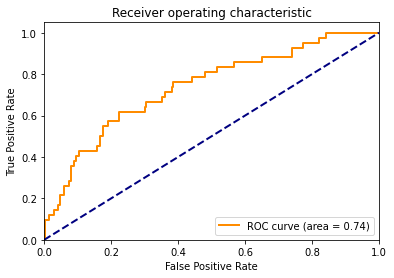

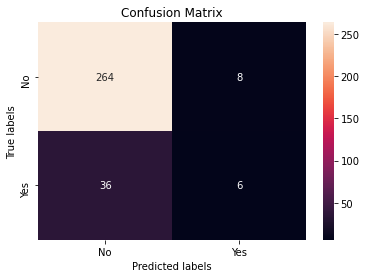

     FP    FN     TP     TN   TPR   TNR   FPR   FNR
0  36.0   8.0  264.0    6.0  0.97  0.14  0.86  0.03
1   8.0  36.0    6.0  264.0  0.14  0.97  0.03  0.86


In [29]:
pred = bst.predict(X_test, num_iteration=bst.best_iteration)
vizReport(y_test, pred) 

In [32]:
bst.save_model('blow_lgb_dart.txt')

In [41]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

target = 'Flow'
regr = SVR(C=1.0, epsilon=.3, kernel='rbf')
X = np.nan_to_num(lvl2_flat_train.to_numpy())
y = Ys_train[target]
# regr.fit(X, y)
# # regr.predict(X)

X_test = np.nan_to_num(lvl2_flat_test.to_numpy())
y_true = Ys_test[target]


svr = SVR()
y_rbf = svr.fit(X, y).predict(X_test)

# Plotting
# plt.figure(1)
# plt.plot(X, y_rbf, c = 'navy', label = 'Predicted')
# plt.legend()
# plt.show()

# Checking prediction error
print("Mean squared error: ", mean_squared_error(y_true, y_rbf, squared=False))

Mean squared error:  2.2418187437717645


In [31]:
y_rbf

array([5.23312435, 5.13708004, 5.14921951, 5.23556476, 5.0777268 ,
       4.82400965, 5.10312452])

In [32]:
Ys_test

Arousal  Flow  Control  Relaxation  Boredom  Apathy  \
pid      date                                                              
NkZptxP4 2021-03-25     5.00  5.33     4.67        5.00     5.67    6.00   
RDzGhySr 2021-03-10     9.00  9.67    10.00        9.33     9.67   10.00   
aMGhMt9R 2021-04-15     4.67  5.33     5.33        4.67     5.00    5.00   
         2021-02-25     3.67  3.33     5.00        5.00     3.33    3.33   
Hq3Pk7py 2021-04-18     7.67  5.67     5.00        5.67     6.67    5.33   
3WxYuamh 2021-03-02    10.00  9.67    10.00        9.33     1.00    1.00   
NTACuoCq 2021-03-10    10.00  7.00     7.00       10.00     1.00    1.00   

                     Worry  Anxiety  
pid      date                        
NkZptxP4 2021-03-25   8.00     6.00  
RDzGhySr 2021-03-10   8.33     9.67  
aMGhMt9R 2021-04-15   4.00     5.00  
         2021-02-25   2.00     3.67  
Hq3Pk7py 2021-04-18   5.00     6.00  
3WxYuamh 2021-03-02   1.00     4.00  
NTACuoCq 2021-03-10   1.00     4.00